# Deep mutational scanning of ZIKV E protein
Deep mutational scanning of ZIKV E from the MR766 strain.
Experiments performed by the [Matt Evans lab](http://labs.icahn.mssm.edu/evanslab/).
Sequencing and computational analyses performed by the [Bloom lab](https://research.fhcrc.org/bloom/en.html).

## Set up for analysis
Import Python packages and modules:

In [1]:
import glob
import os
import subprocess
import collections
import warnings

warnings.simplefilter('ignore') # ignore warnings that clutter output

import numpy
import pandas
import Bio.SeqIO
import Bio.Phylo
from IPython.display import display, HTML
import matplotlib.pyplot as plt

import phydmslib
import phydmslib.utils
print(f"Using phydms {phydmslib.__version__}")

import dms_tools2
from dms_tools2.ipython_utils import showPDF
print(f"Using dms_tools2 {dms_tools2.__version__}")

Using phydms 2.3.1
Using dms_tools2 2.3.0


Specify information about running analysis:

In [2]:
use_existing = 'yes' # use existing output

ncpus = 16 # max CPUs to use

# directories
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

Input data found in the [./data/](data) directory:

In [3]:
refseqfile = './data/E.fasta' # sequence of wildtype gene
samplelist = './data/samplelist.csv' # samples sequenced
alignspecsfile = './data/subamplicon_alignspecs.txt'

Read in the wildtype (reference) sequence and its protein translation:

In [4]:
refseqrecord = Bio.SeqIO.read(refseqfile, 'fasta')
refprot = str(refseqrecord.seq.translate())
refseq = str(refseqrecord.seq)

print(f"Read wildtype (reference) sequence of {len(refseq)} nucleotides "
      f"that translates to protein of {len(refprot)} amino acids.")

Read wildtype (reference) sequence of 1512 nucleotides that translates to protein of 504 amino acids.


## Process deep sequencing data
We process the data from the [barcoded subamplicon deep sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to count the frequency of each codon in each sample.

First, we read in the samples:

In [5]:
samples = (pandas.read_csv(samplelist)
           .assign(name=lambda x: x.library + '-' + x.selection)
           )

display(HTML(samples.to_html(index=False)))

library,selection,antibody,percent_infectivity,R1,name
Lib1,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib1-plasmid
Lib2,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib2-plasmid
Lib3,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib3-plasmid
wildtype,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,wildtype-plasmid
Lib1,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib1-virus
Lib2,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib2-virus
Lib3,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib3-virus
wildtype,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,wildtype-virus
Lib1,no-antibody,no-antibody,71.06000,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib1-no-antibody
Lib2,no-antibody,no-antibody,132.77000,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib2-no-antibody


Now we read in the alignment specs for the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html):

In [6]:
with open(alignspecsfile) as f:
    alignspecs = f.read().strip()
print(alignspecs)

1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35


Now we use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) program to process the deep sequencing data to obtain codon counts:

In [7]:
countsdir = os.path.join(resultsdir, 'codoncounts')
os.makedirs(countsdir, exist_ok=True)

bcsubamp_batchfile = os.path.join(countsdir, 'batch.csv')
samples[['name', 'R1']].to_csv(bcsubamp_batchfile, index=False)

log = ! dms2_batch_bcsubamp \
        --batchfile {bcsubamp_batchfile} \
        --refseq {refseqfile} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 200 \
        --ncpus {ncpus} \
        --use_existing {use_existing}

samples['codoncounts'] = countsdir + '/' + samples['name'] + '_codoncounts.csv'

# check that expected codon counts files created
assert all(map(os.path.isfile, samples.codoncounts))

print(f"Processed sequencing data to create codon counts files in {countsdir}")

Processed sequencing data to create codon counts files in ./results/codoncounts


Now we look at the plots.
They will all have the following prefix:

In [8]:
bcsubamp_plot_prefix = os.path.join(countsdir, 'summary_')

First, we look at the number of reads and barcodes per sample.
We have plenty of reads for all samples. 
We also have good numbers of aligned barcodes for most samples, but some (particularly, *Lib1-ZKA185*) have very few barcodes.
This probably indicates a problem with bottlenecking the number of molecules going from round 1 to round 2 of the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html).

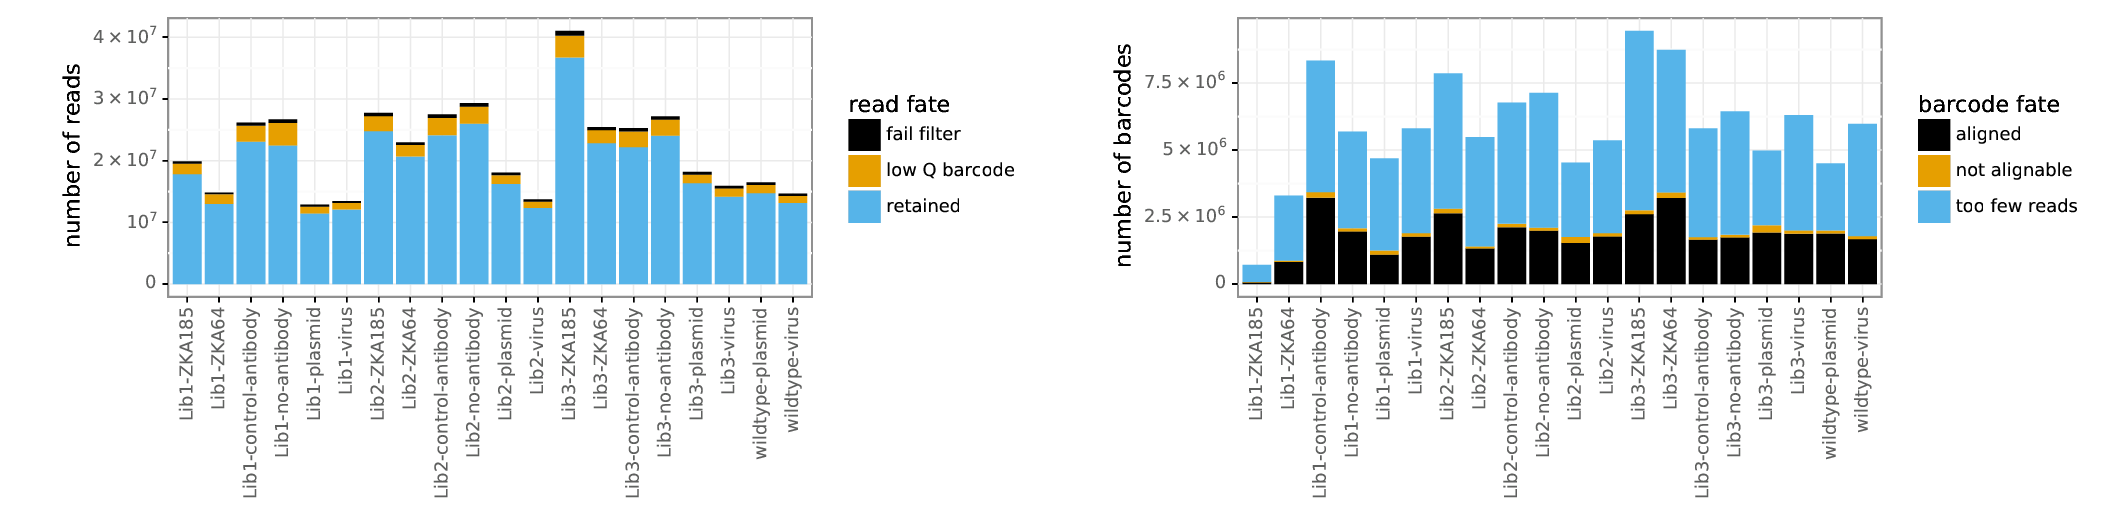

In [9]:
showPDF([bcsubamp_plot_prefix + 'readstats.pdf',
         bcsubamp_plot_prefix + 'bcstats.pdf'])

Next we look at number of reads per barcode.
In all cases, we appear to have over-sequenced (or conversely, bottlenecked too much going from round 1 to round 2) as most barcodes are sequenced > 2 times except for singletons that probably represent sequencing errors. 
This problem is especially sever for *Lib1-ZKA185*, which is probably why we have so few barcodes for this sample.
This does mean that the sequences for the barcodes we did get will be highly reliable, however:

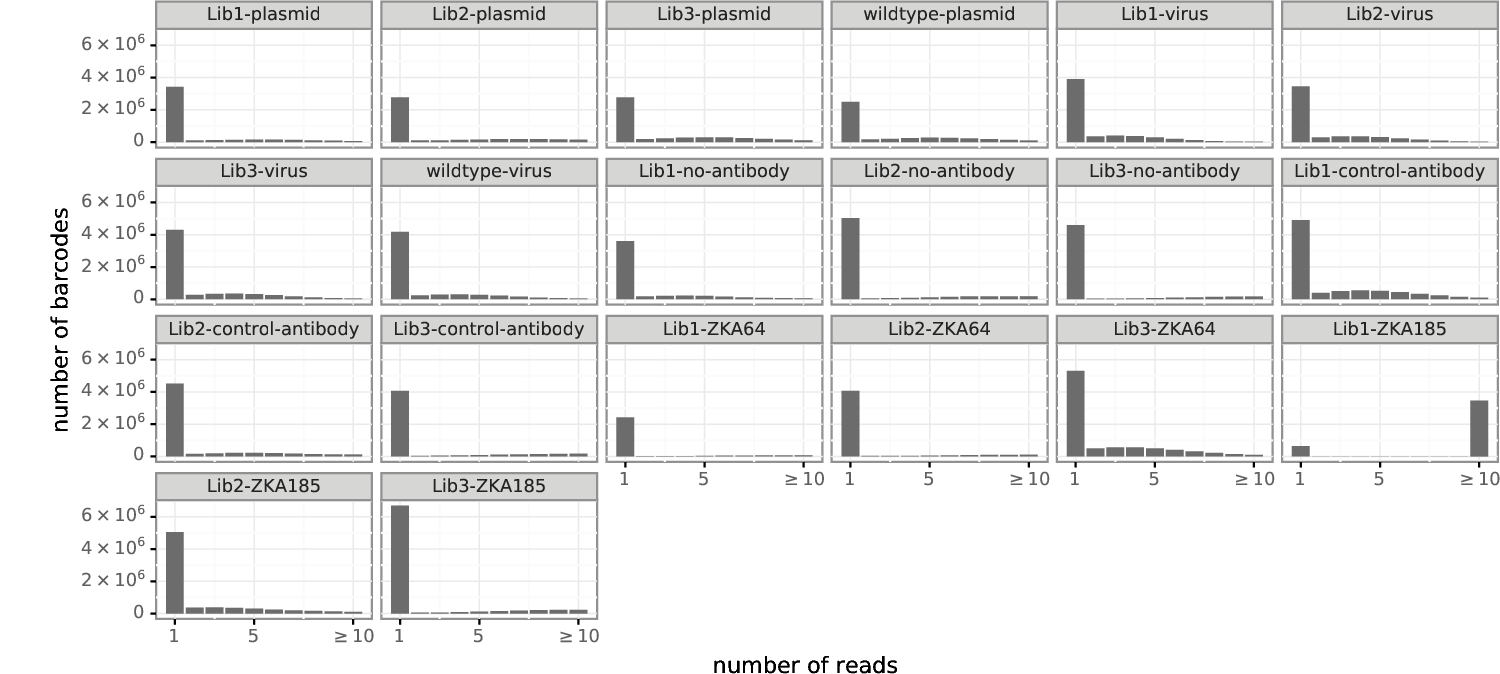

In [10]:
showPDF(bcsubamp_plot_prefix + 'readsperbc.pdf')

Now we look at the depth across the gene.
Except for *Lib1-ZKA185*, the depth seems sufficient for all samples:

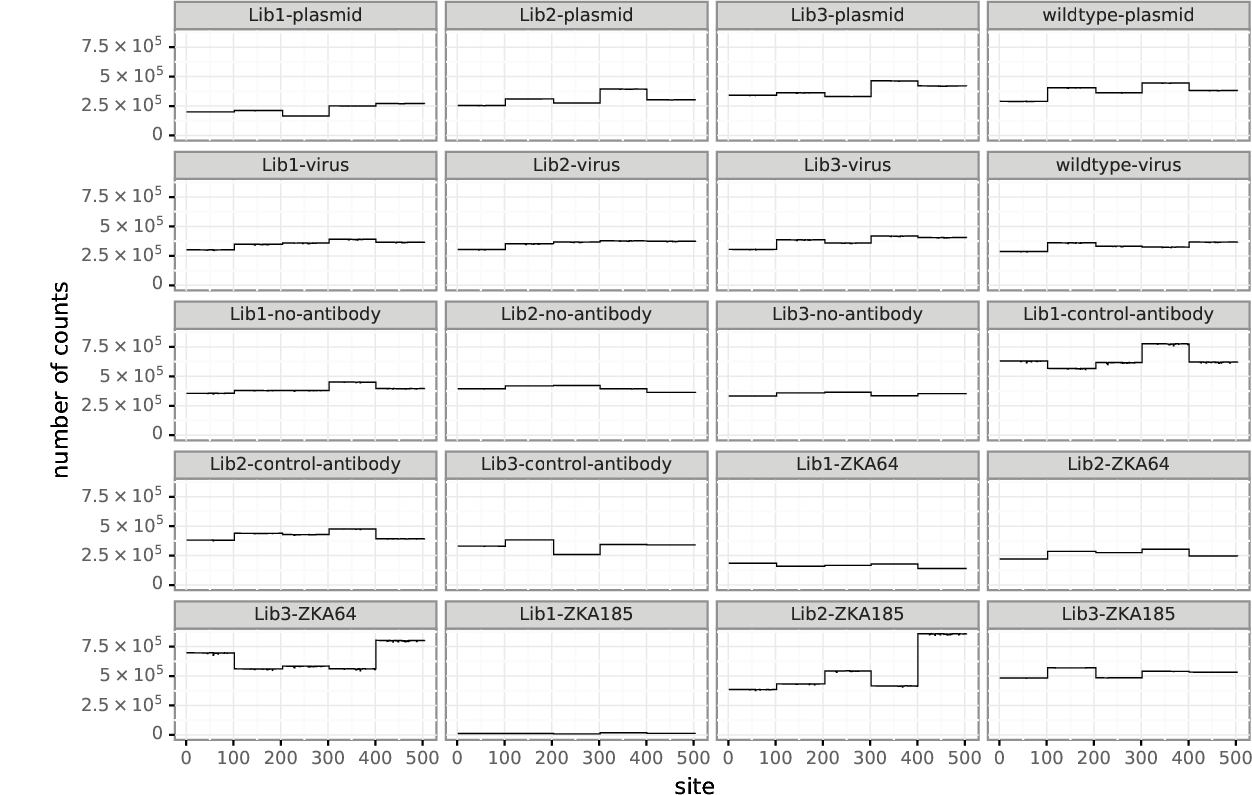

In [11]:
showPDF(bcsubamp_plot_prefix + 'depth.pdf')

Here are the mutation frequencies across the gene.
As expected, there are big peaks in the antibody selected samples, probably because the antibodies selected mutations.
We'll have to wait until more detailed analyses below to tell if these peaks make sense as being escape mutations.

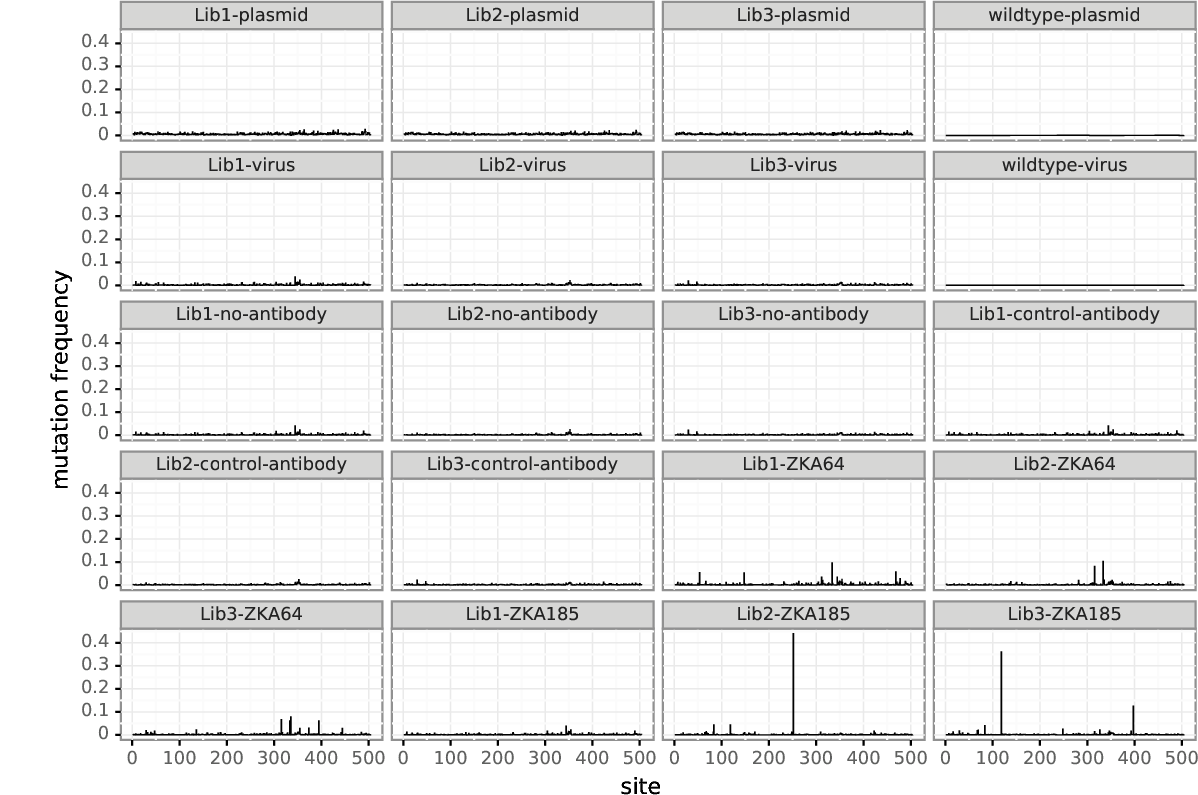

In [12]:
showPDF(bcsubamp_plot_prefix + 'mutfreq.pdf')

We also see that as expected, we get strong selection against stop codons in all samples except the unselected input plasmid library:

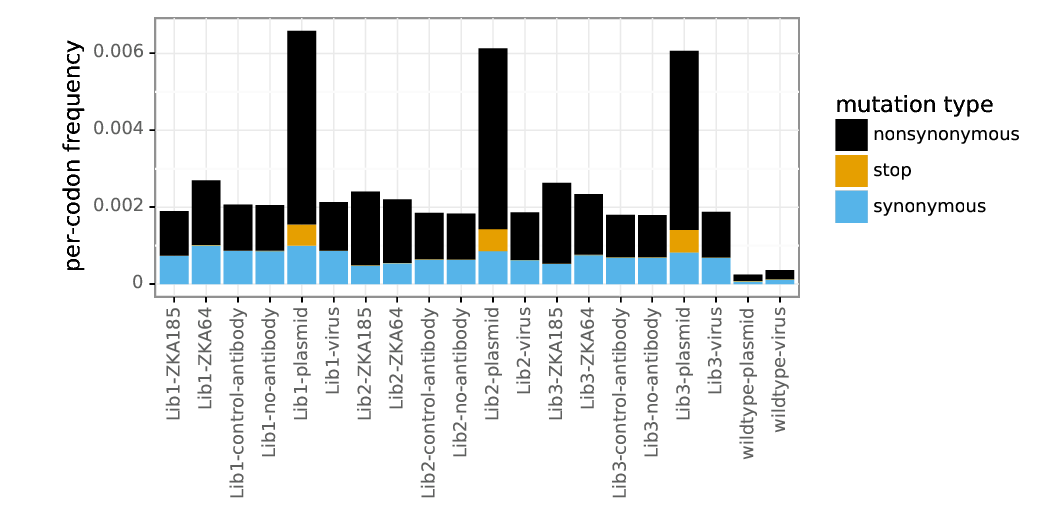

In [13]:
showPDF(bcsubamp_plot_prefix + 'codonmuttypes.pdf')

We have single and multi-nucleotide changes in the libraries, although the single nucleotide changes are perhaps over-represented:

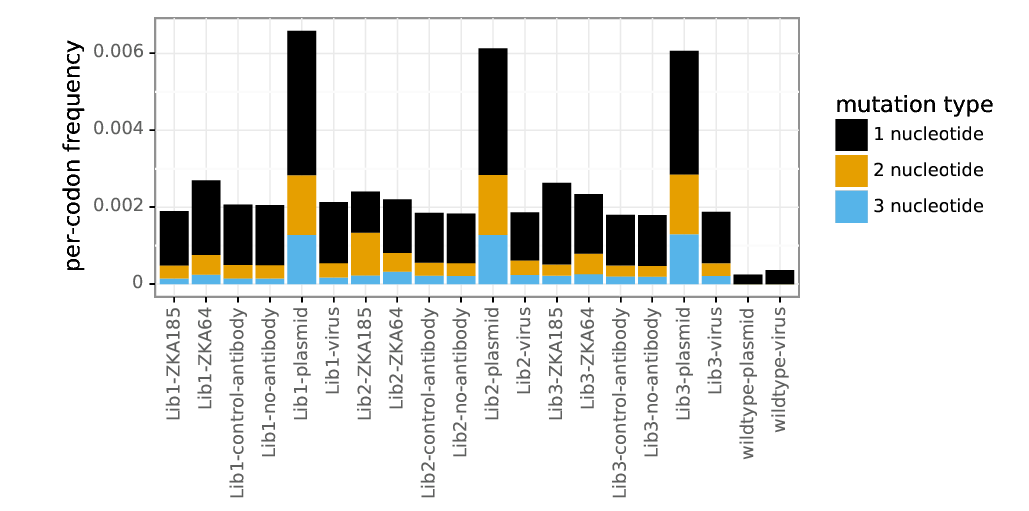

In [14]:
showPDF(bcsubamp_plot_prefix + 'codonntchanges.pdf')

Here are the frequencies of different types of mutations among single-nucleotide codon changes.
We see that unfortunately there does appear to be some oxidative damage to the plasmid samples:Z

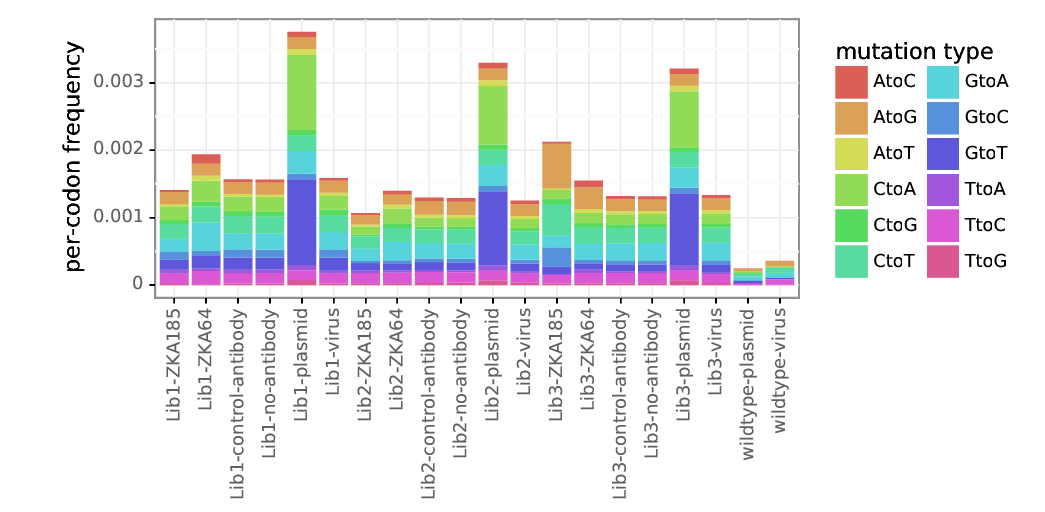

In [15]:
showPDF(bcsubamp_plot_prefix + 'singlentchanges.pdf')

Finally, we look at mutation sampling.
We can see that all possible mutations are sampled very well in the plasmid samples, and that mutation frequencies decrease a lot (as expected due to selection) in the other samples.

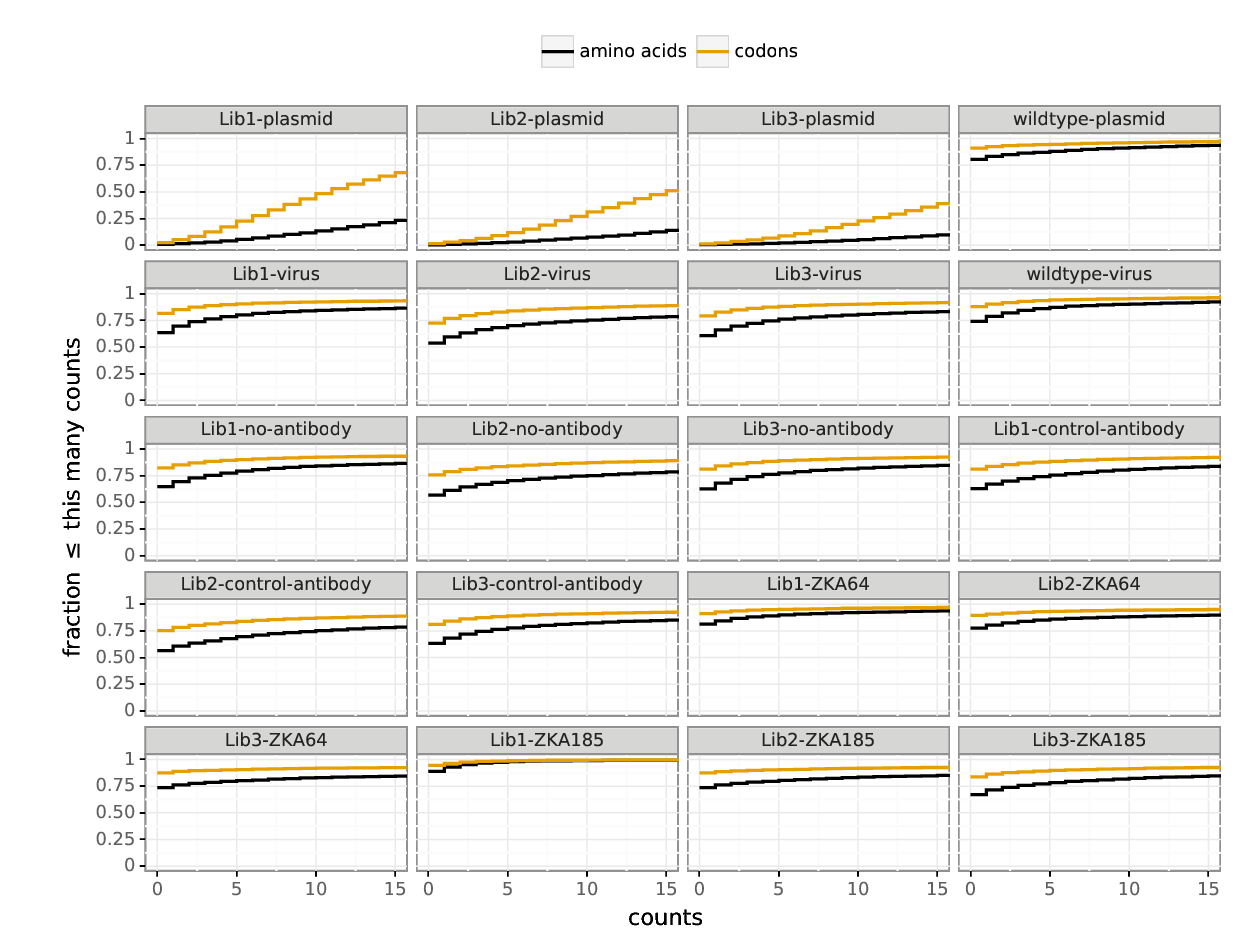

In [16]:
showPDF(bcsubamp_plot_prefix + 'cumulmutcounts.pdf')

## Amino-acid preferences under functional selection
Now we compute the amino-acid preferences under functional selection for viral growth.
To do this, we compare the passaged *virus* samples to the original *plasmid* samples, using the wildtype *plasmid* and *virus* samples as controls to estimate the error rates.
We run the analysis using [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html).

First, construct the data frame with the batch file:

In [17]:
prefs_batch = collections.defaultdict(list)

for lib in samples.library.unique():
    if lib != 'wildtype':
        prefs_batch['name'].append(lib)
        prefs_batch['pre'].append(f'{lib}-plasmid')
        prefs_batch['post'].append(f'{lib}-virus')
        prefs_batch['errpre'].append('wildtype-plasmid')
        prefs_batch['errpost'].append('wildtype-virus')
        
prefs_batch = pandas.DataFrame(prefs_batch)

display(HTML(prefs_batch.to_html(index=False)))

name,pre,post,errpre,errpost
Lib1,Lib1-plasmid,Lib1-virus,wildtype-plasmid,wildtype-virus
Lib2,Lib2-plasmid,Lib2-virus,wildtype-plasmid,wildtype-virus
Lib3,Lib3-plasmid,Lib3-virus,wildtype-plasmid,wildtype-virus


Now run [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html):

In [18]:
prefsdir = os.path.join(resultsdir, 'prefs')
os.makedirs(prefsdir, exist_ok=True)

prefs_batchfile = os.path.join(prefsdir, 'batch.csv')
prefs_batch.to_csv(prefs_batchfile, index=False)

log = ! dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing}

assert all(map(os.path.isfile, [os.path.join(prefsdir, lib + '_prefs.csv') 
                                for lib in prefs_batch.name]))

print("Amino-acid preferences calculated for all libraries.")

Amino-acid preferences calculated for all libraries.


Look at the correlation among the amino-acid preferences calculated for the individual libraries:

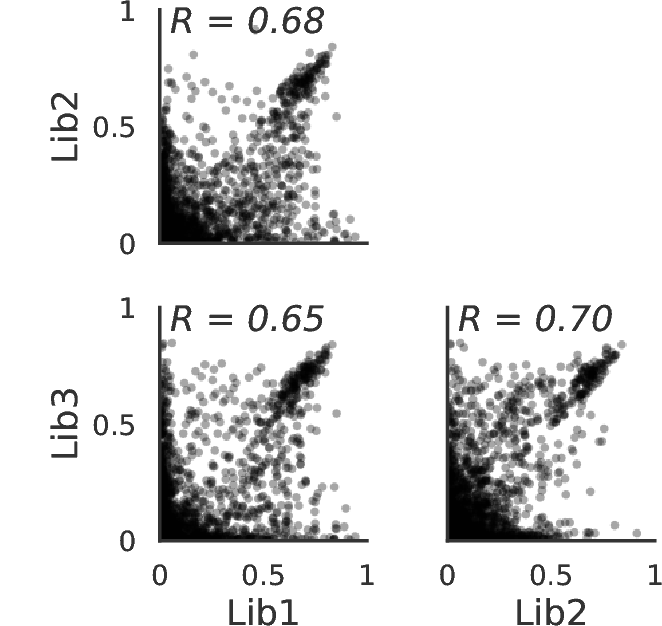

In [19]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'))

Now we will make a logo plot of the average of the amino-acid preferences across the libraries.
We do this using [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).
Note that this logo plot shows the raw unscaled (**not** re-scaled) preferences:

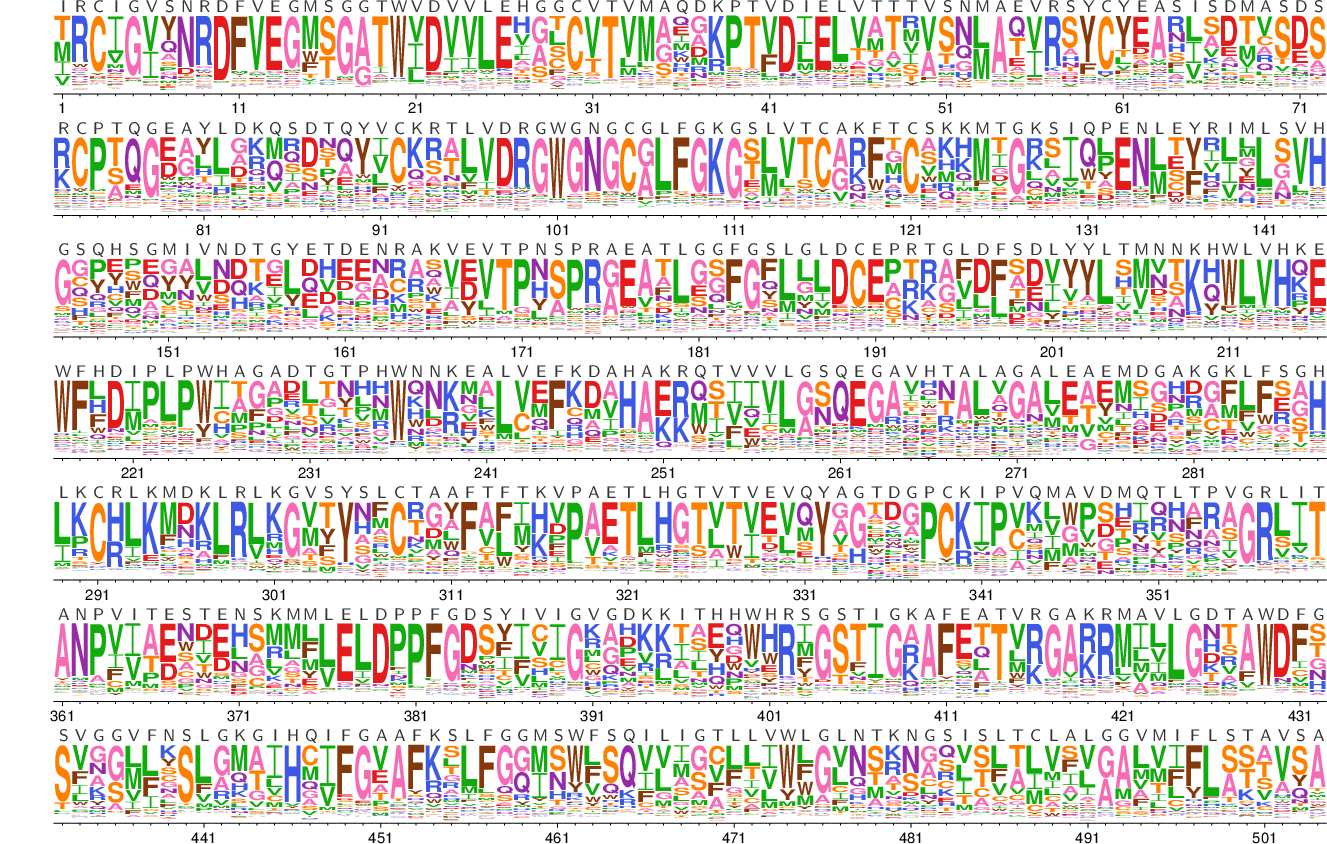

In [20]:
logodir = os.path.join(resultsdir, 'logoplots')
os.makedirs(logodir, exist_ok=True)

# more sensibly named file with unscaled average prefs
unscaledprefsfile = os.path.join(prefsdir, 'unscaled_prefs.csv')
! cp {os.path.join(prefsdir, 'summary_avgprefs.csv')} {unscaledprefsfile}

wtoverlayfile = os.path.join(logodir, 'wt_overlay.csv')
with open(wtoverlayfile, 'w') as f:
    f.write('site,wildtype\n')
    for r, a in enumerate(refprot):
        f.write(f'{r + 1},{a}\n')

log = ! dms2_logoplot \
        --prefs {unscaledprefsfile} \
        --name unscaled \
        --outdir {logodir} \
        --nperline 72 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --use_existing {use_existing}

showPDF(os.path.join(logodir, 'unscaled_prefs.pdf'))

## Phylogenetic analyses with experimentally informed codon models
Now we perform phylogenetic analyses with experimentally informed codon models (ExpCM) that use the deep mutational scanning data (see [here](https://peerj.com/articles/3657/) for background on ExpCMs).

Set up directory for these analyses:

In [21]:
phylodir = os.path.join(resultsdir, 'phylogenetics/')
os.makedirs(phylodir, exist_ok=True)

We have a manually curated alignment of Zika virus E protein coding sequences in [./data/E_alignment.fasta](data/E_alignment.fasta):

In [22]:
alignment_file = './data/E_alignment.fasta'

alignment = list(Bio.SeqIO.parse(alignment_file, 'fasta'))
print(f"There are {len(alignment)} sequences in {alignment_file}")

There are 85 sequences in ./data/E_alignment.fasta


Now we run [phydms](http://jbloomlab.github.io/phydms/) (using the [phydms_comprehensive](http://jbloomlab.github.io/phydms/phydms_comprehensive_prog.html) program) to fit ExpCM and standard codon models to these sequences:

In [23]:
modelcomparisonfile = os.path.join(phylodir, 'phydms_modelcomparison.md')

if not os.path.isfile(modelcomparisonfile) or use_existing != 'yes':
    ! cp {unscaledprefsfile} {os.path.join(phylodir, 'prefs.csv')}
    log = ! phydms_comprehensive \
            {os.path.join(phylodir, 'phydms')} \
            {alignment_file} \
            {unscaledprefsfile} \
            --raxml raxmlHPC \
            --ncpus {ncpus}
    assert os.path.isfile(modelcomparisonfile)

Let's visualize the phylogenetic tree.
The topology will be the same for the tree under any model, so let's look at it under the ExpCM:

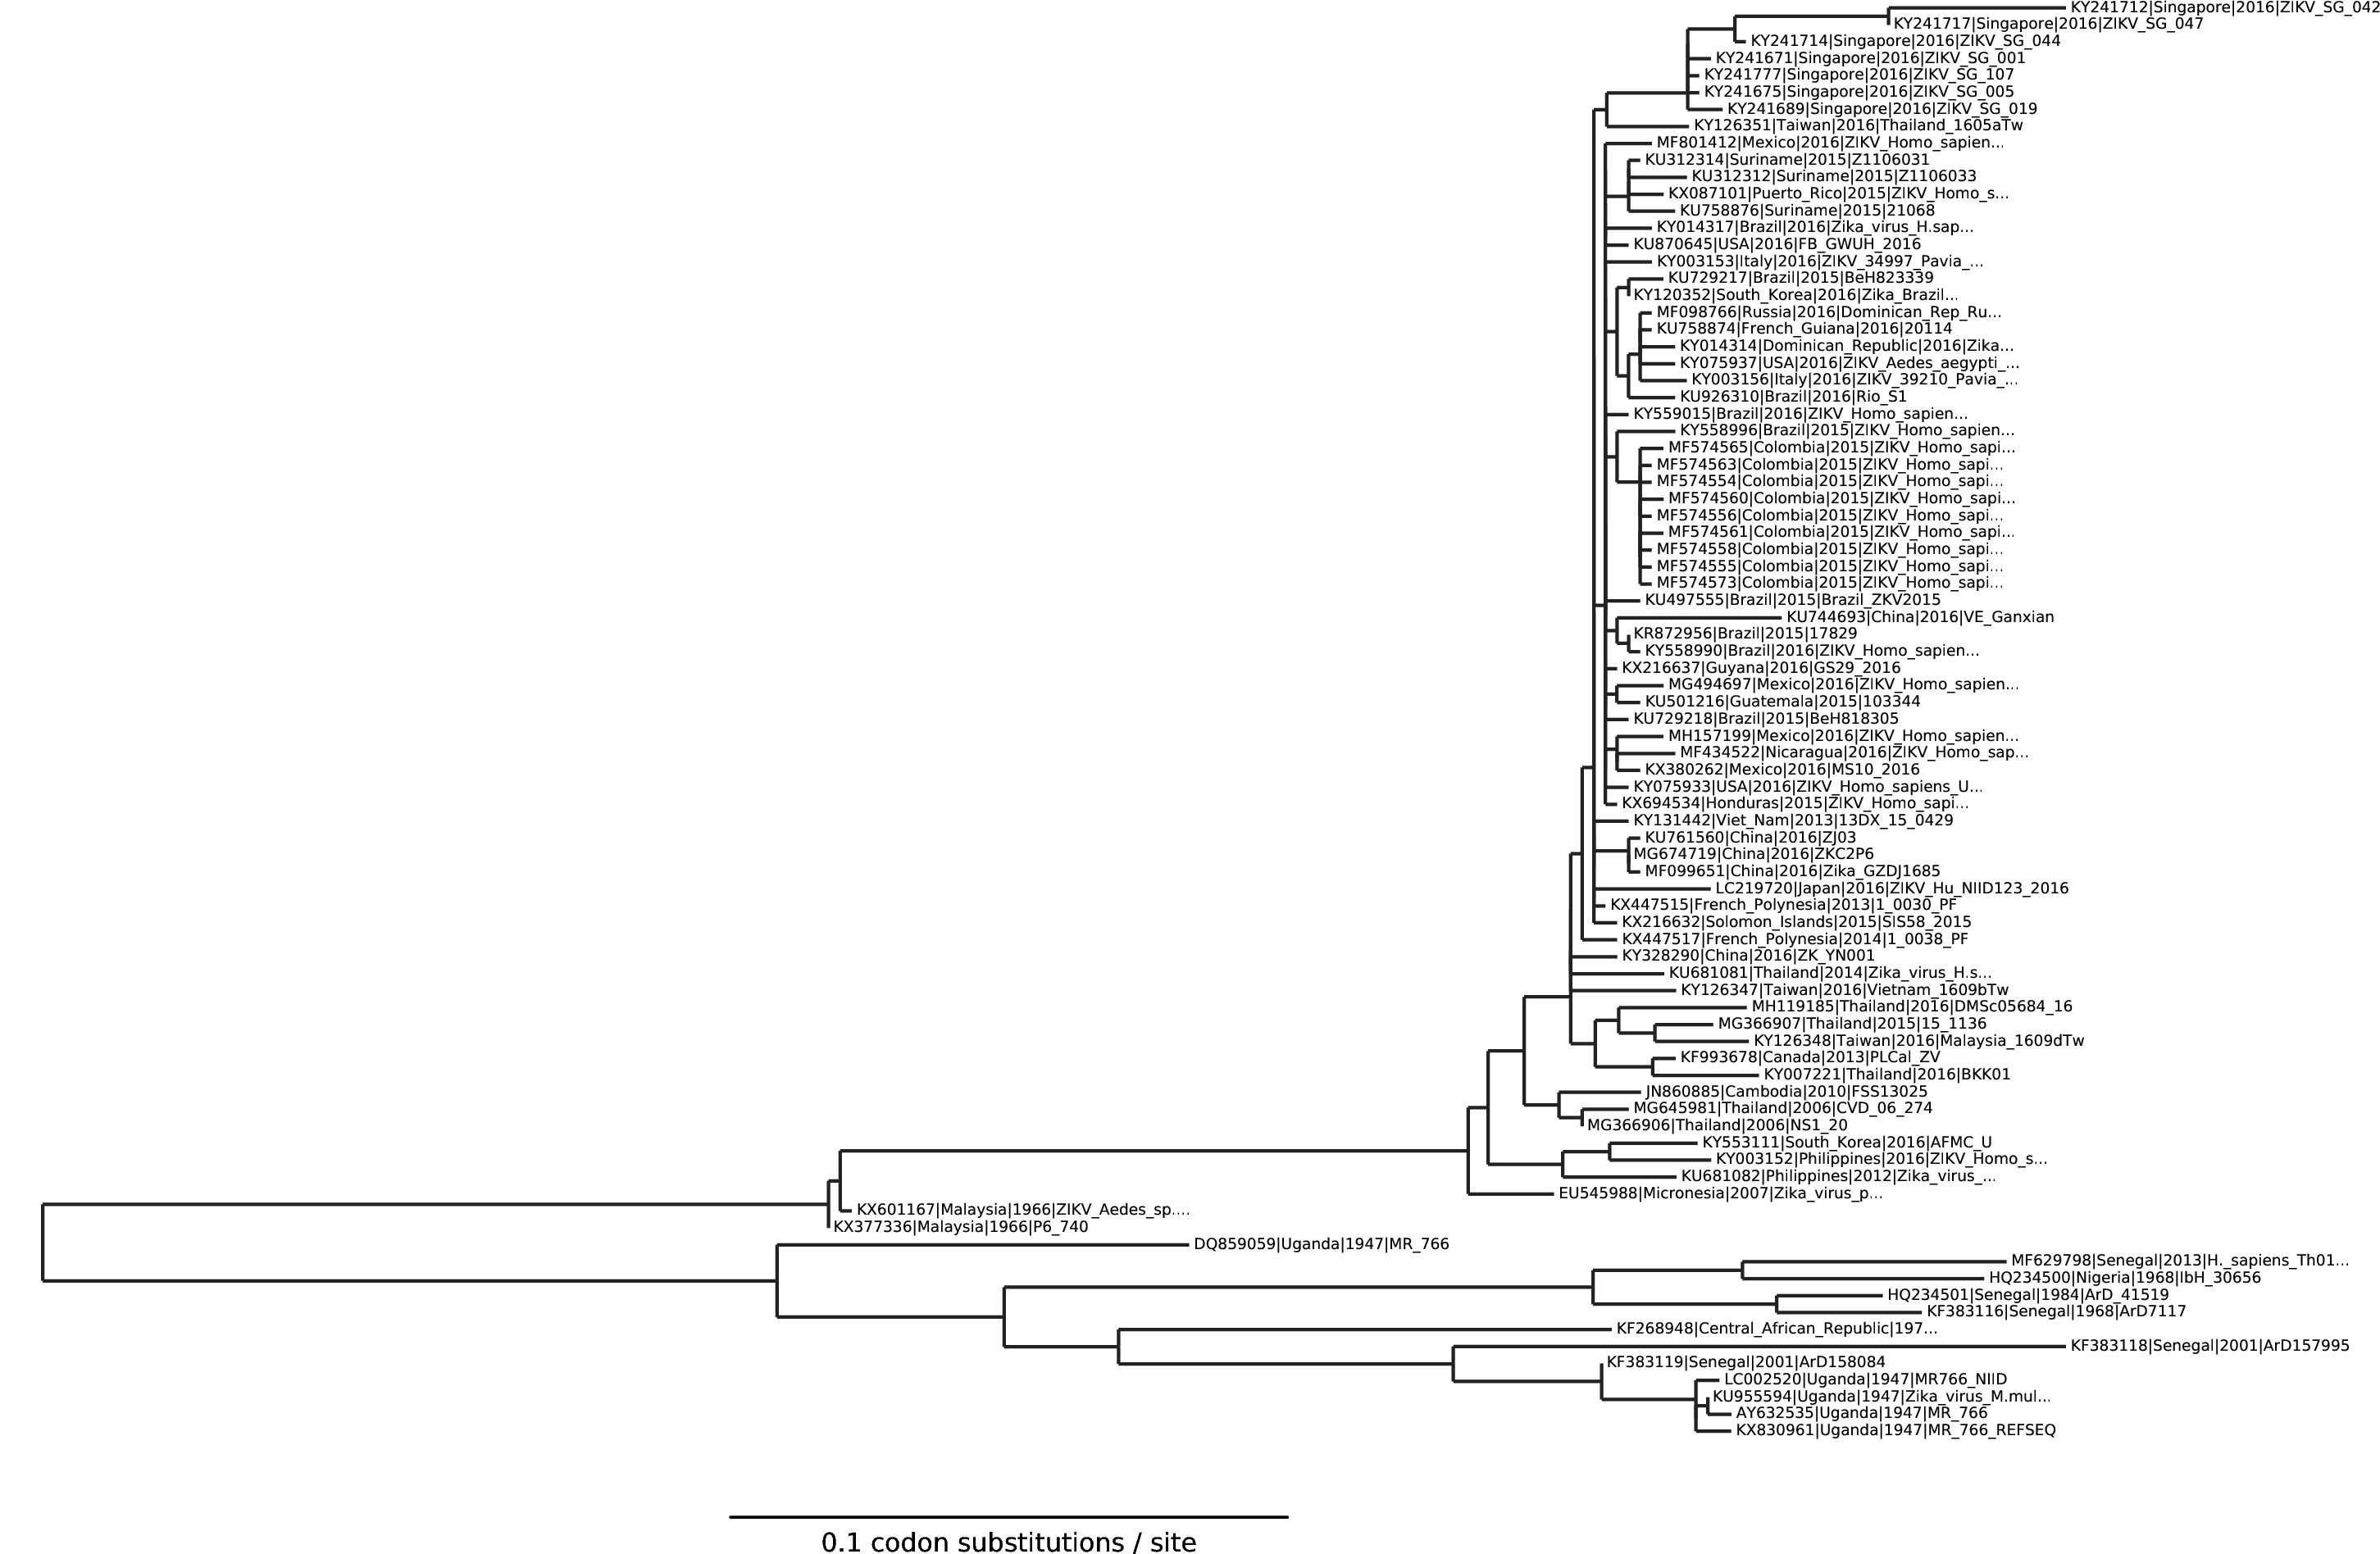

In [24]:
treefile = os.path.join(phylodir, 'phydms_ExpCM_prefs_tree.newick')
treefigfile = os.path.join(phylodir, 'tree.pdf')

# read tree
tree = Bio.Phylo.read(treefile, 'newick')
tree.root_at_midpoint()

# plot and format tree
Bio.Phylo.draw(tree,
               do_show=False)
treefig = plt.gcf()
treefig.set_size_inches(25, 15)
ax = treefig.axes[0]
ax.axis('off')

# add scale bar
(x0, x1, y0, y1) = plt.axis()
xstart = x0 + 0.3 * (x1 - x0)
barlen = 0.1
yline = y0 - 0.05 * (y1 - y0)
ytext = yline - 0.01 * (y1 - y0)
ax.set_ylim(ytext, y1)
plt.plot([xstart, xstart + barlen], [yline, yline], color='black', 
          linestyle='-', linewidth=2)
plt.text(xstart + barlen / 2., ytext, 
         f'{barlen} codon substitutions / site',
         horizontalalignment='center',
         verticalalignment='top',
         color='black',
         fontsize=17)

treefig.tight_layout()
treefig.savefig(treefigfile)
plt.close()

showPDF(treefigfile)

Now let's look at the result of the phylogenetic model comparison from the analysis.
We see below that the ExpCM is the best model by far:

In [25]:
# read model comparison to dataframe for gamma-omega models
modelcompare = (phydmslib.utils.modelComparisonDataFrame(
                modelcomparisonfile, splitparams=True)
        .assign(avgomega=lambda x: x.alpha_omega / x.beta_omega)
        [['Model', 'deltaAIC', 'LogLikelihood', 'nParams', 'beta', 
          'omega', 'avgomega', 'alpha_omega', 'beta_omega']]
        .rename(columns={'beta':'stringency', 'deltaAIC':'$\Delta$AIC',
                'avgomega':'$\overline{\omega}$', 'kappa':'$\kappa$', 
                'alpha_omega':'$\omega_{\\alpha}$', 
                'beta_omega':'$\omega_{\\beta}$',
                'omega':'$\omega$'})
        )

display(HTML(modelcompare.to_html(index=False)))

Model,$\Delta$AIC,LogLikelihood,nParams,stringency,$\omega$,$\overline{\omega}$,$\omega_{\alpha}$,$\omega_{\beta}$
ExpCM_prefs,0.00,-5585.50,6,1.48,0.33,NaN,NaN,NaN
YNGKP_M5,2031.02,-6595.01,12,NaN,NaN,0.09188,0.43,4.68
averaged_ExpCM_prefs,2033.54,-6602.27,6,0.49,0.09,NaN,NaN,NaN
YNGKP_M0,2059.88,-6610.44,11,NaN,0.09,NaN,NaN,NaN


Extract the stringency parameter from the ExpCM to use to re-scale the preferences to better align with the strength of natural selection (see [here](https://peerj.com/articles/3657/)).
The fact that we have a stringency parameter > 1 means that natural selection favors the same amino acids in the experiment, but more stringently:

In [26]:
stringency = float(modelcompare.set_index('Model')['stringency'].to_dict()['ExpCM_prefs'])

print(f"Stringency parameter is {stringency}")

Stringency parameter is 1.48


Re-scale the preferences by this stringency parameter and write to a file:

In [27]:
unscaledprefs = pandas.read_csv(unscaledprefsfile)
rescaledprefs = dms_tools2.prefs.rescalePrefs(unscaledprefs, stringency)

rescaledprefsfile = os.path.join(prefsdir, 'rescaled_prefs.csv')
rescaledprefs.to_csv(rescaledprefsfile, index=False)
print(f"Re-scaled prefs written to {rescaledprefsfile}")

Re-scaled prefs written to ./results/prefs/rescaled_prefs.csv


Now make a logo plot of the **re-scaled** preferences:

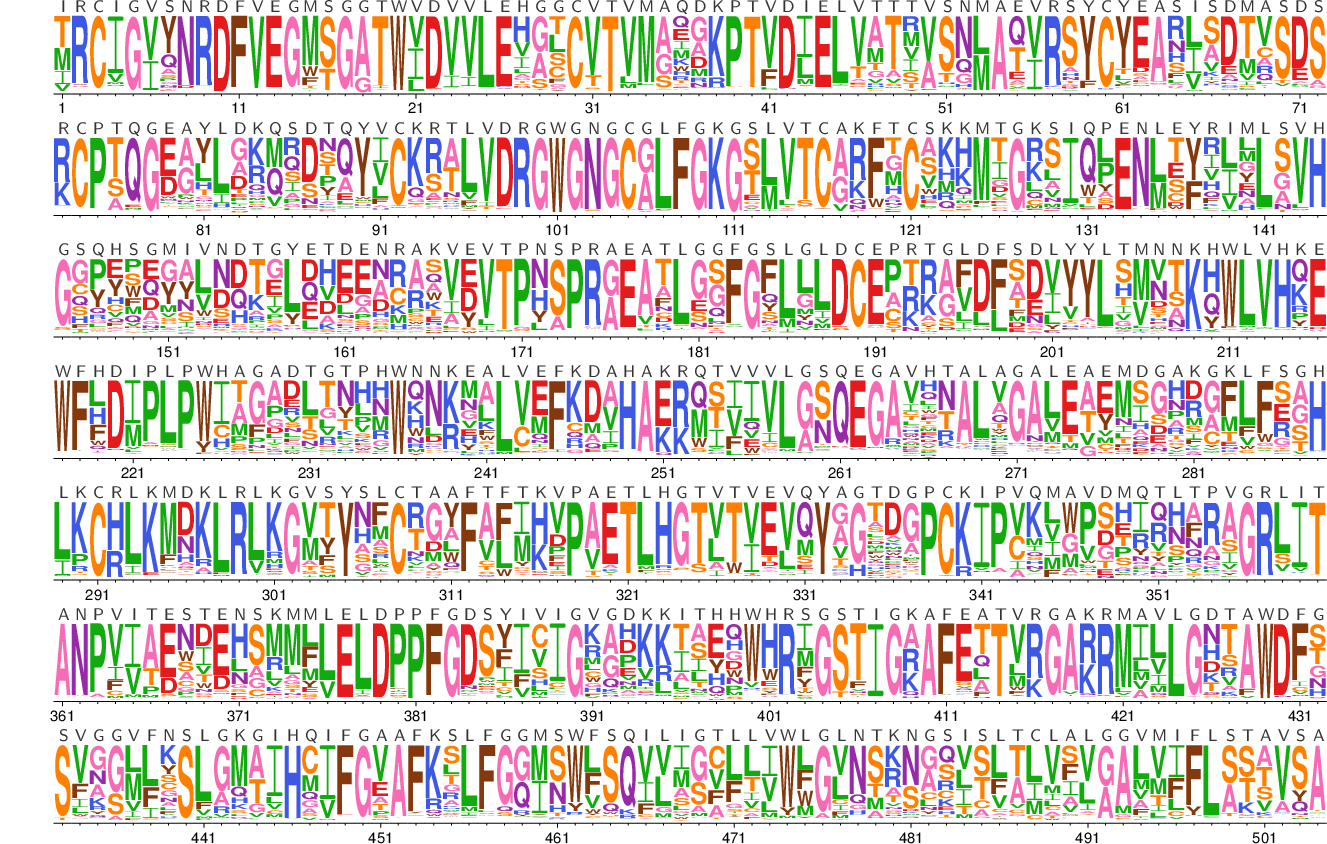

In [28]:
log = ! dms2_logoplot \
        --prefs {rescaledprefsfile} \
        --name rescaled \
        --outdir {logodir} \
        --nperline 72 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --use_existing {use_existing}

showPDF(os.path.join(logodir, 'rescaled_prefs.pdf'))

## Differential selection
We now compute the [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) from each antibody selection.
We do this using [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).

In [29]:
diffseldir = os.path.join(resultsdir, 'diffsel')
os.makedirs(diffseldir, exist_ok=True)

Now we create a batch file for running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html).
Note that we use the "no antibody" condition as our mock selection, and our wildtype virus as our error control:

In [30]:
diffsel_batch = (
    samples
    .assign(sel=lambda x: x['name'],
            mock=lambda x: x['library'] + '-no-antibody',
            err='wildtype-virus',
            libfracsurvive=lambda x:
                numpy.clip(x.percent_infectivity / 100, None, 1)
            )
    .query('antibody not in ["none", "no-antibody"]')
    .rename(columns={'antibody':'group', 'library':'name'})
    [['group', 'name', 'sel', 'mock', 'err',
      'percent_infectivity', 'libfracsurvive']]
    )

display(HTML(diffsel_batch.to_html(index=False)))

group,name,name,sel,mock,err,percent_infectivity,libfracsurvive
control-antibody,Lib1,Lib1-control-antibody,Lib1-control-antibody,Lib1-no-antibody,wildtype-virus,104.65000,1.000000
control-antibody,Lib2,Lib2-control-antibody,Lib2-control-antibody,Lib2-no-antibody,wildtype-virus,67.35000,0.673500
control-antibody,Lib3,Lib3-control-antibody,Lib3-control-antibody,Lib3-no-antibody,wildtype-virus,80.14000,0.801400
ZKA64,Lib1,Lib1-ZKA64,Lib1-ZKA64,Lib1-no-antibody,wildtype-virus,2.34000,0.023400
ZKA64,Lib2,Lib2-ZKA64,Lib2-ZKA64,Lib2-no-antibody,wildtype-virus,1.54000,0.015400
ZKA64,Lib3,Lib3-ZKA64,Lib3-ZKA64,Lib3-no-antibody,wildtype-virus,2.21000,0.022100
ZKA185,Lib1,Lib1-ZKA185,Lib1-ZKA185,Lib1-no-antibody,wildtype-virus,0.00059,0.000006
ZKA185,Lib2,Lib2-ZKA185,Lib2-ZKA185,Lib2-no-antibody,wildtype-virus,1.93000,0.019300
ZKA185,Lib3,Lib3-ZKA185,Lib3-ZKA185,Lib3-no-antibody,wildtype-virus,1.39000,0.013900


We see that ZKA185 Lib1 has a **very low** percent infectivity, indicating that nearly all the library was neutralized.
Also, when we plotted the mutation frequency line plots above, this one looked different (no real signal).
Probably we just have noise when the neutralization is that strong, so we filter samples (i.e. ZKA185 Lib1) with percent infectivity less than 0.01%.

In [31]:
diffsel_batch = diffsel_batch.query('percent_infectivity > 0.01')

display(HTML(diffsel_batch.to_html(index=False)))

group,name,name,sel,mock,err,percent_infectivity,libfracsurvive
control-antibody,Lib1,Lib1-control-antibody,Lib1-control-antibody,Lib1-no-antibody,wildtype-virus,104.65,1.0000
control-antibody,Lib2,Lib2-control-antibody,Lib2-control-antibody,Lib2-no-antibody,wildtype-virus,67.35,0.6735
control-antibody,Lib3,Lib3-control-antibody,Lib3-control-antibody,Lib3-no-antibody,wildtype-virus,80.14,0.8014
ZKA64,Lib1,Lib1-ZKA64,Lib1-ZKA64,Lib1-no-antibody,wildtype-virus,2.34,0.0234
ZKA64,Lib2,Lib2-ZKA64,Lib2-ZKA64,Lib2-no-antibody,wildtype-virus,1.54,0.0154
ZKA64,Lib3,Lib3-ZKA64,Lib3-ZKA64,Lib3-no-antibody,wildtype-virus,2.21,0.0221
ZKA185,Lib2,Lib2-ZKA185,Lib2-ZKA185,Lib2-no-antibody,wildtype-virus,1.93,0.0193
ZKA185,Lib3,Lib3-ZKA185,Lib3-ZKA185,Lib3-no-antibody,wildtype-virus,1.39,0.0139


Write to the batch file: 

In [32]:
diffsel_batchfile = os.path.join(diffseldir, 'batch.csv')
diffsel_batch.to_csv(diffsel_batchfile, index=False)

Now run [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html):

In [33]:
log = ! dms2_batch_diffsel \
        --batchfile {diffsel_batchfile} \
        --summaryprefix summary \
        --indir {countsdir} \
        --outdir {diffseldir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

Now let's look at the plots summarizing the results.

First, we examine the correlation between replicates. 
We do this for the positive site differential selection, in our prior work (e.g., [Doud et al (2017)](https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1006271) and [Dingens et al (2017)](https://www.sciencedirect.com/science/article/pii/S1931312817301968?via%3Dihub)), this has been the most useful differential selection statistic.
The plots below show fairly good correlations for the two anti-Zika virus antibodies, but much less correlation for the control antibody.
This is expected since the control antibody experiment is probably mostly noise and has much lower overall differential selection:

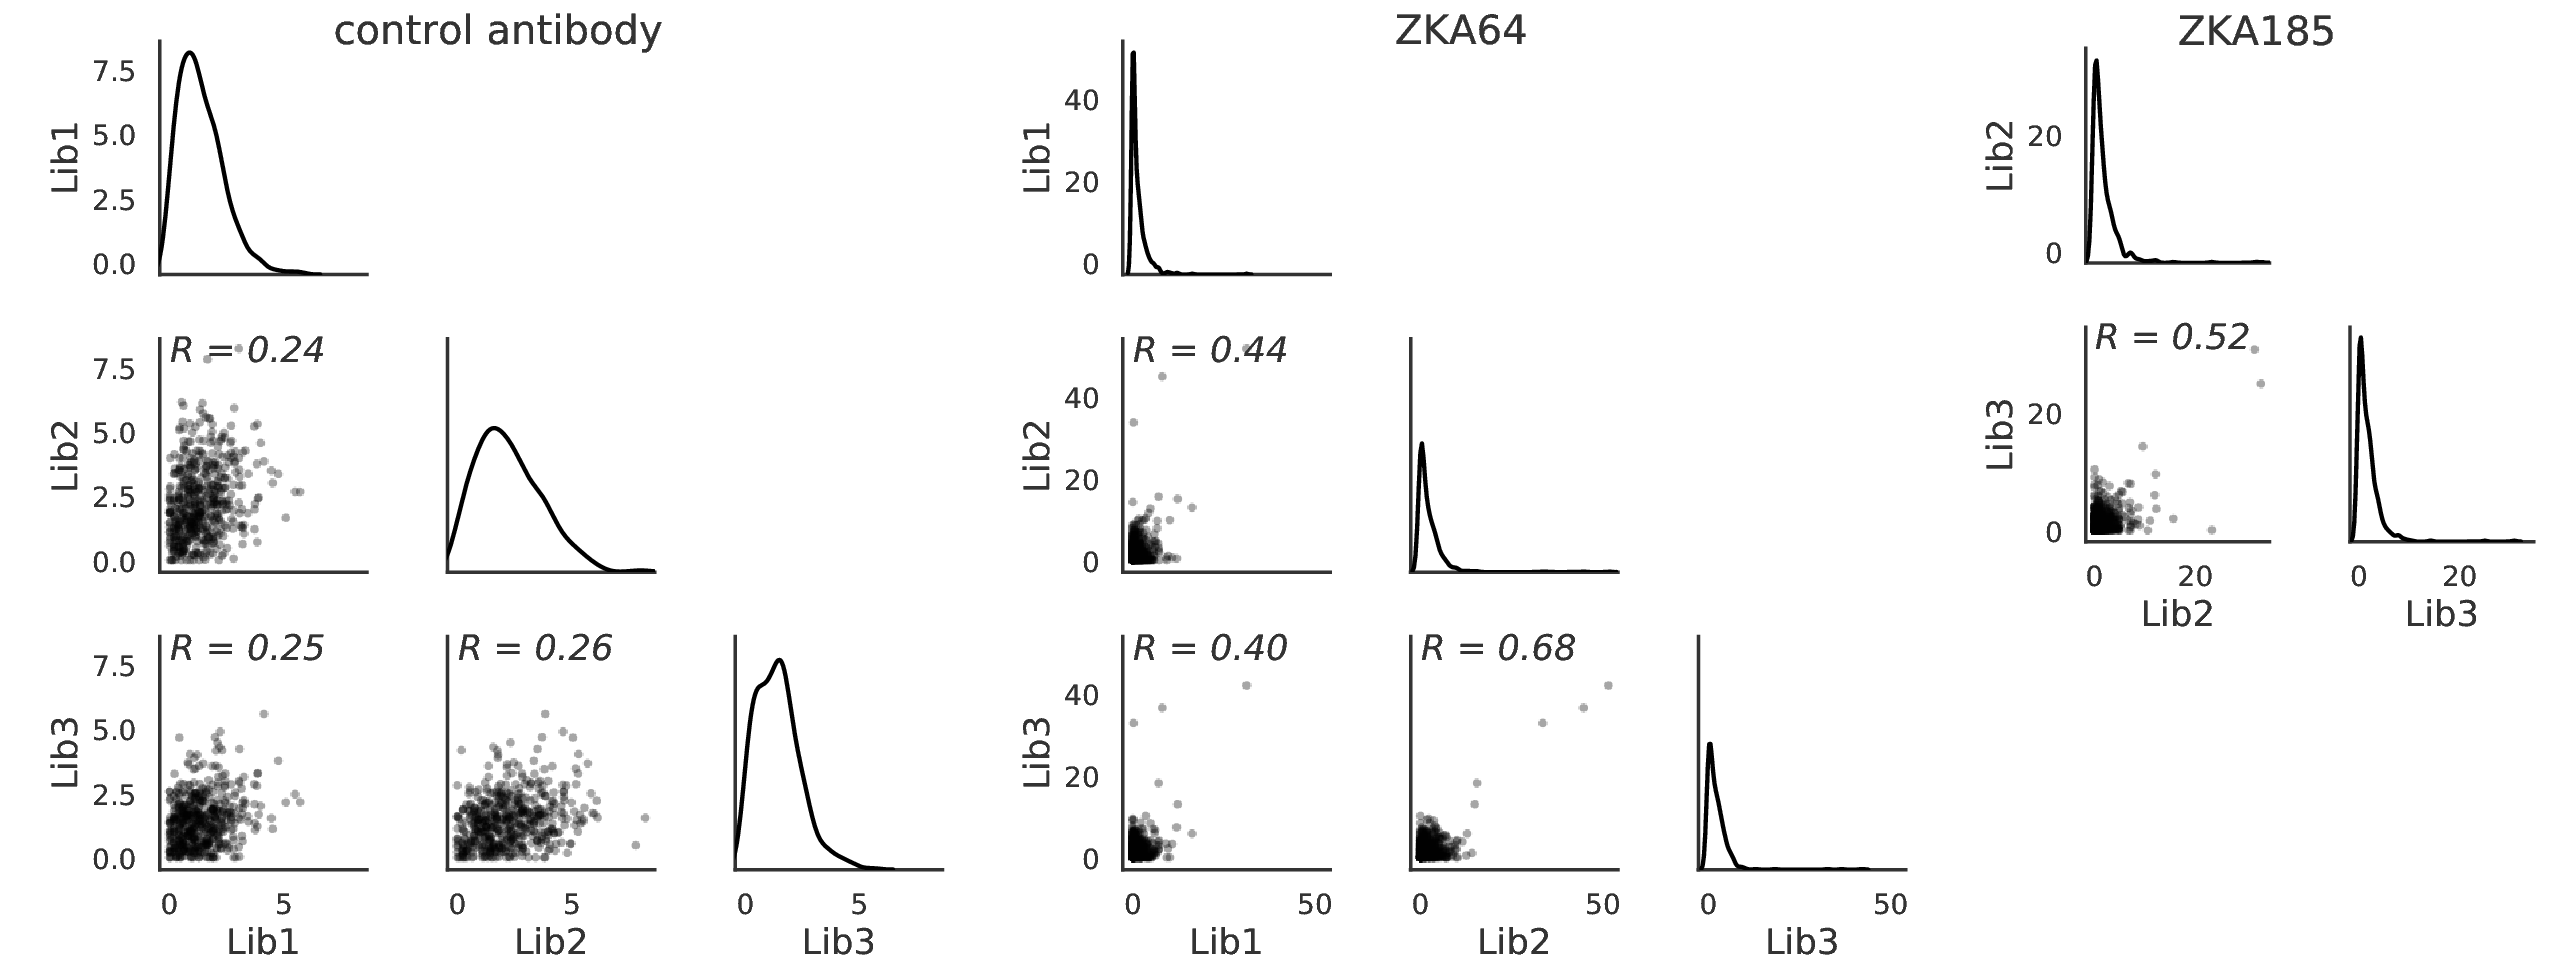

In [34]:
showPDF([os.path.join(diffseldir, f'summary_{antibody}-positivesitediffselcorr.pdf')
         for antibody in diffsel_batch['group'].unique()])

Now we look at the positive differential selection for each antibody, taking the average across the replicates.
We see clear peaks of differentially selected sites for both antibodies, but no peaks for the control antibody:

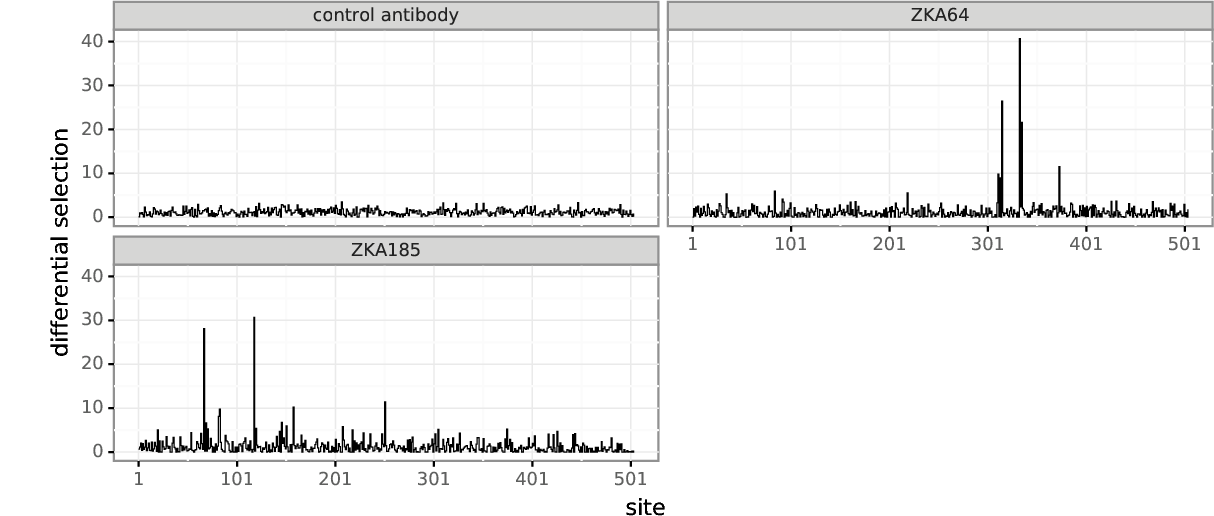

In [35]:
showPDF(os.path.join(diffseldir, 'summary_meanpositivediffsel.pdf'))

We also look at the total differential selection, including **negative** differential selection.
So far in all our work, we have never determined if this negative differential selection is meaningful.
Still, we plot it in case it actually indicates sites where mutations increase neutralization sensitivity (it might also be spurious signal):

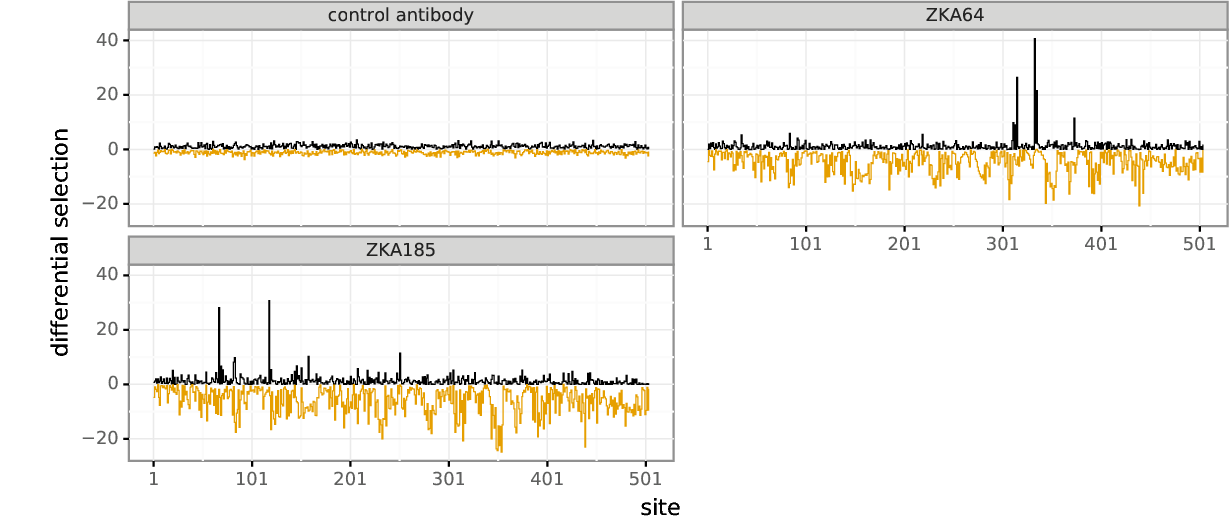

In [36]:
showPDF(os.path.join(diffseldir, 'summary_meantotaldiffsel.pdf'))

Finally, we use [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html) to make a logo plot of the across-replicate average **positive** (not use of `--restrictdiffsel positive`) differential selection for each non-control antibody:



Diffsel for ZKA64 (plot saved to ./results/logoplots/ZKA64_diffsel.pdf):


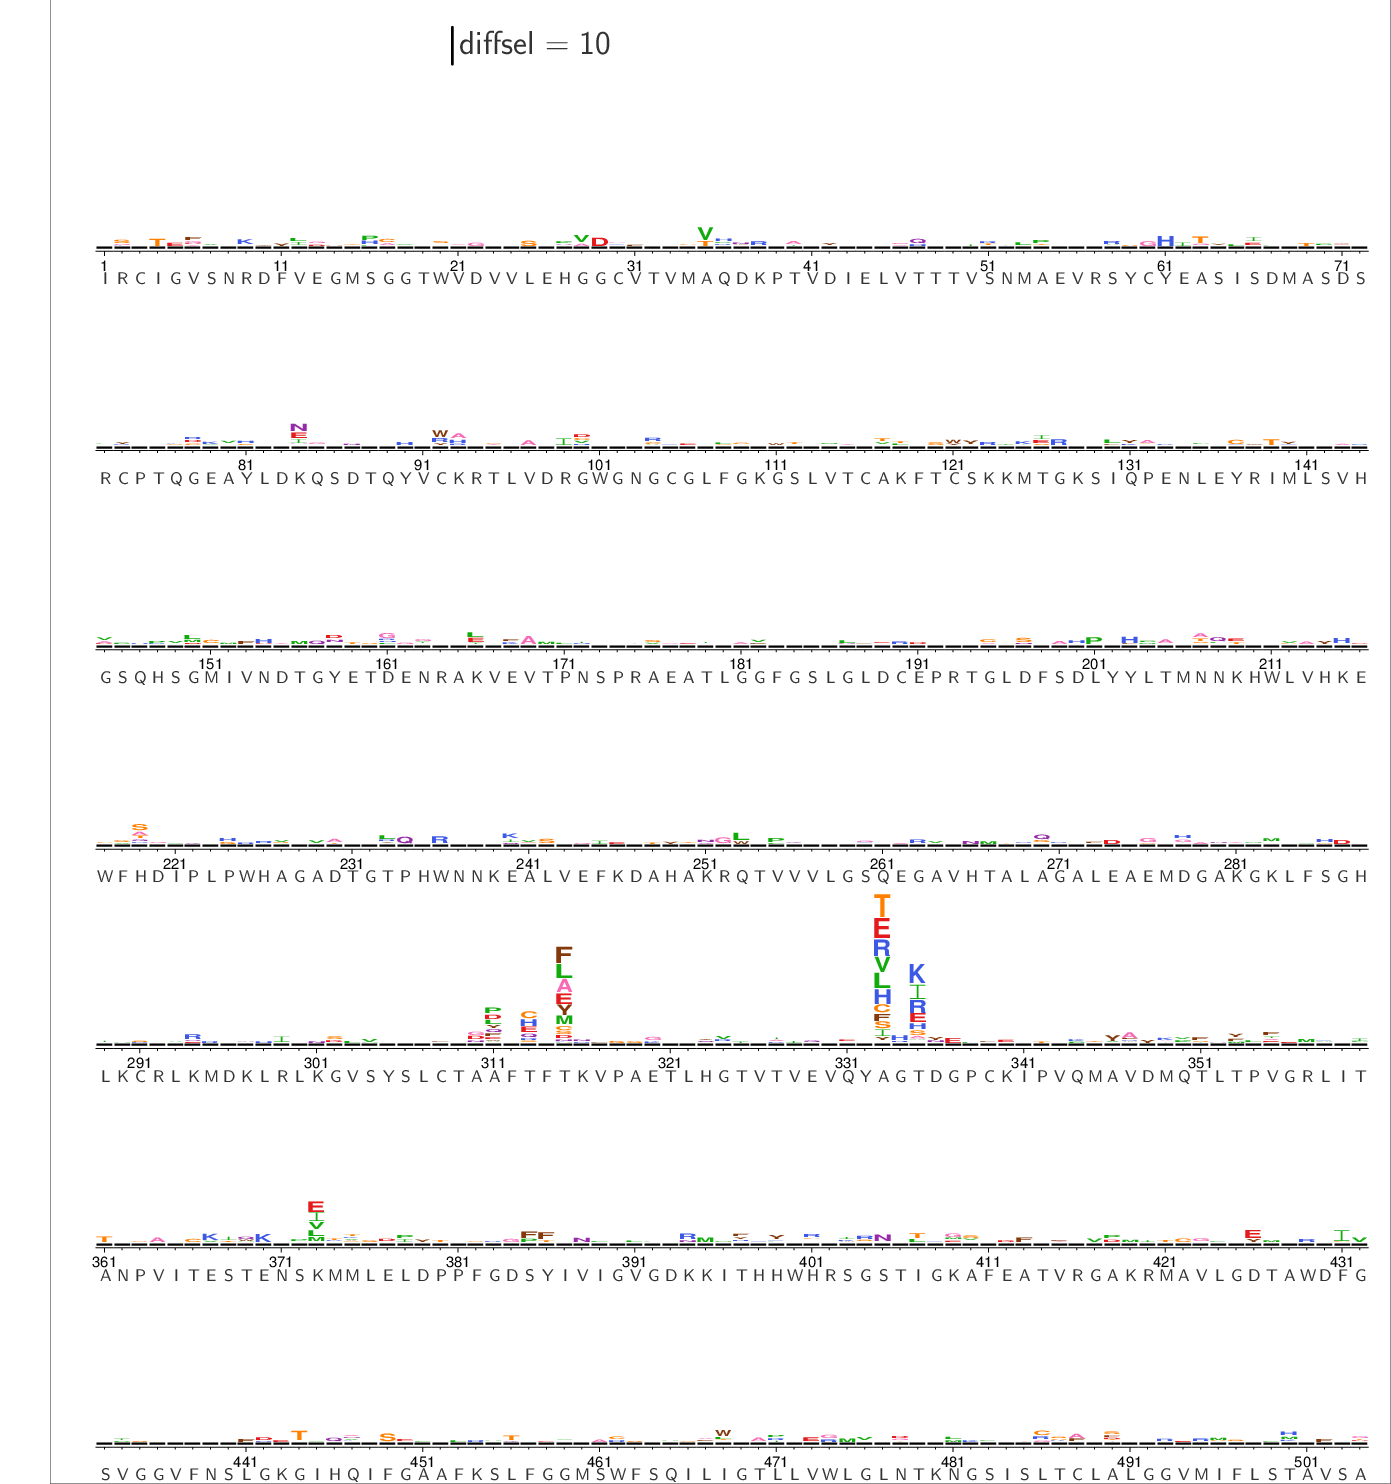



Diffsel for ZKA185 (plot saved to ./results/logoplots/ZKA185_diffsel.pdf):


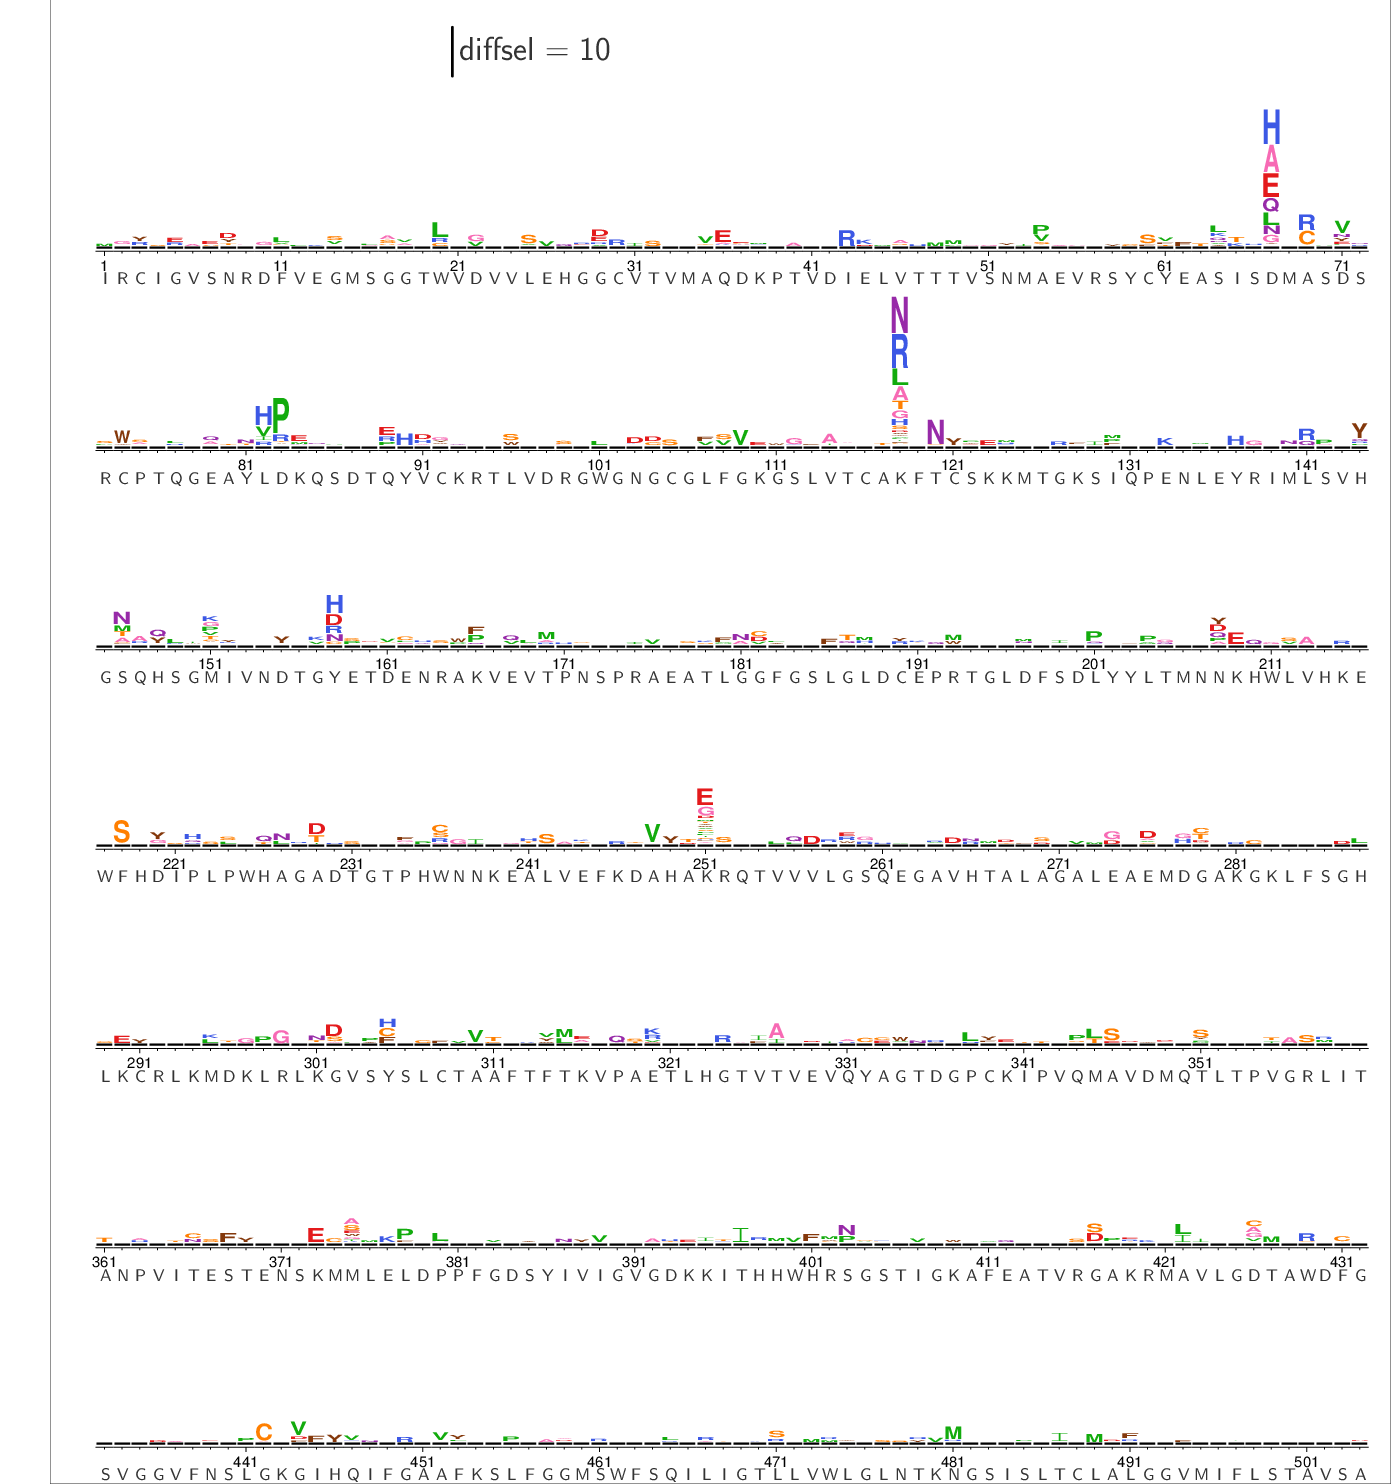

In [37]:
for antibody in diffsel_batch.query('group != "control-antibody"').group.unique():
    logoplot = os.path.join(logodir, f"{antibody}_diffsel.pdf")
    diffselfile = os.path.join(diffseldir,
                               f'summary_{antibody}-meanmutdiffsel.csv')
    print(f"\n\nDiffsel for {antibody} (plot saved to {logoplot}):")
    log = ! dms2_logoplot \
        --outdir {logodir} \
        --name {antibody} \
        --diffsel {diffselfile} \
        --restrictdiffsel positive \
        --nperline 72 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --scalebar 10 "diffsel = 10" \
        --underlay yes \
        --use_existing {use_existing}
    showPDF(logoplot)

## Fraction surviving
A second way to look at sites of antibody selection is to calculate the [fraction surviving](https://jbloomlab.github.io/dms_tools2/fracsurvive.html) for virions with each mutations.

Here we do this, using the [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) program.
Note that we calculate the **excess** fraction surviving (or fraction surviving above average) by using the `--aboveavg yes` flag.

First, we write the batch file for [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html), which can be the same one we used for differential selection above:

In [38]:
fracsurvivedir = os.path.join(resultsdir, 'fracsurvive')
os.makedirs(fracsurvivedir, exist_ok=True)

fracsurvive_batchfile = os.path.join(fracsurvivedir, 'batch.csv')
diffsel_batch.to_csv(fracsurvive_batchfile, index=False)

Now run [dms2_batch_fracsurvive](https://jbloomlab.github.io/dms_tools2/dms2_batch_fracsurvive.html) (note the use of the `--aboveavg yes` flag): 

In [39]:
log = ! dms2_batch_fracsurvive \
        --batchfile {fracsurvive_batchfile} \
        --summaryprefix summary \
        --aboveavg yes \
        --indir {countsdir} \
        --outdir {fracsurvivedir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

Here are the correlations among replicates:

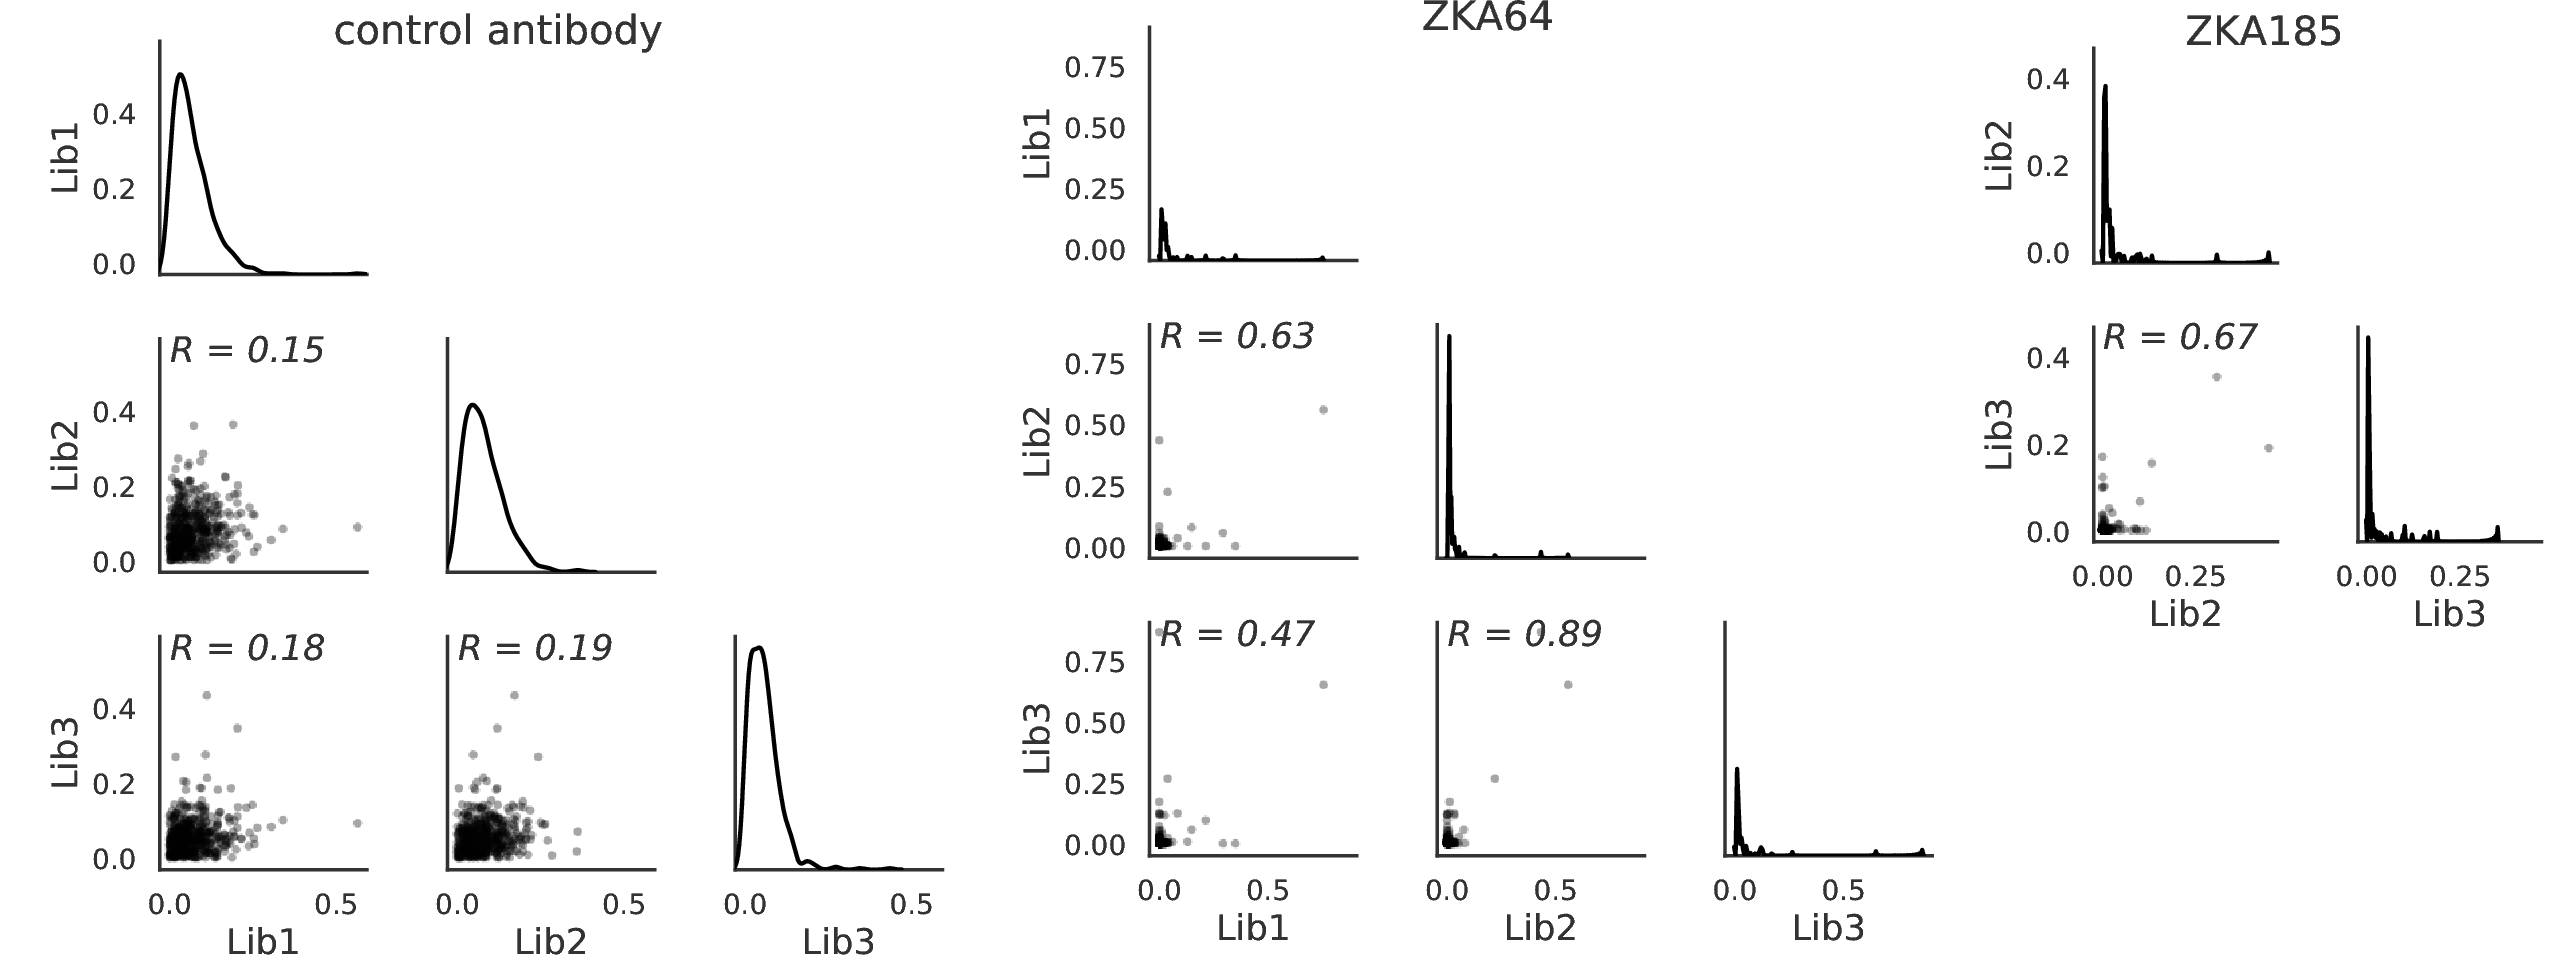

In [40]:
showPDF([os.path.join(fracsurvivedir, f'summary_{antibody}-avgfracsurvivecorr.pdf')
         for antibody in diffsel_batch['group'].unique()])

Here is the average across replicates of each site's average fracsurvive:

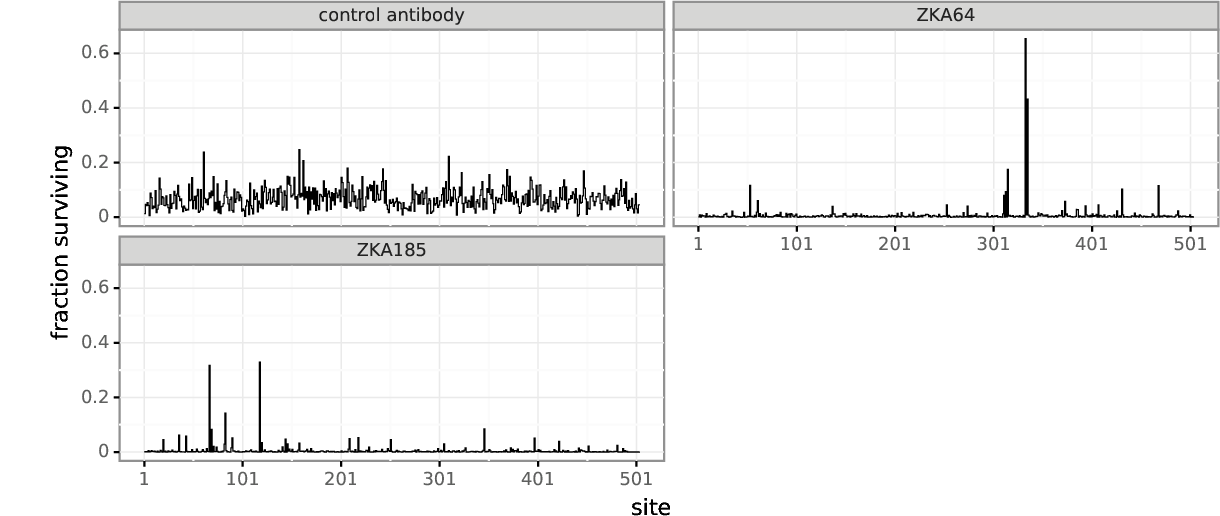

In [41]:
showPDF(os.path.join(fracsurvivedir, 'summary_meanavgfracsurvive.pdf'))

Finally, we use [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html) to make a logo plot of the across-replicate fraction surviving for each non-control antibody:



Fracsurvive for ZKA64 (plot saved to ./results/logoplots/ZKA64_fracsurvive.pdf):


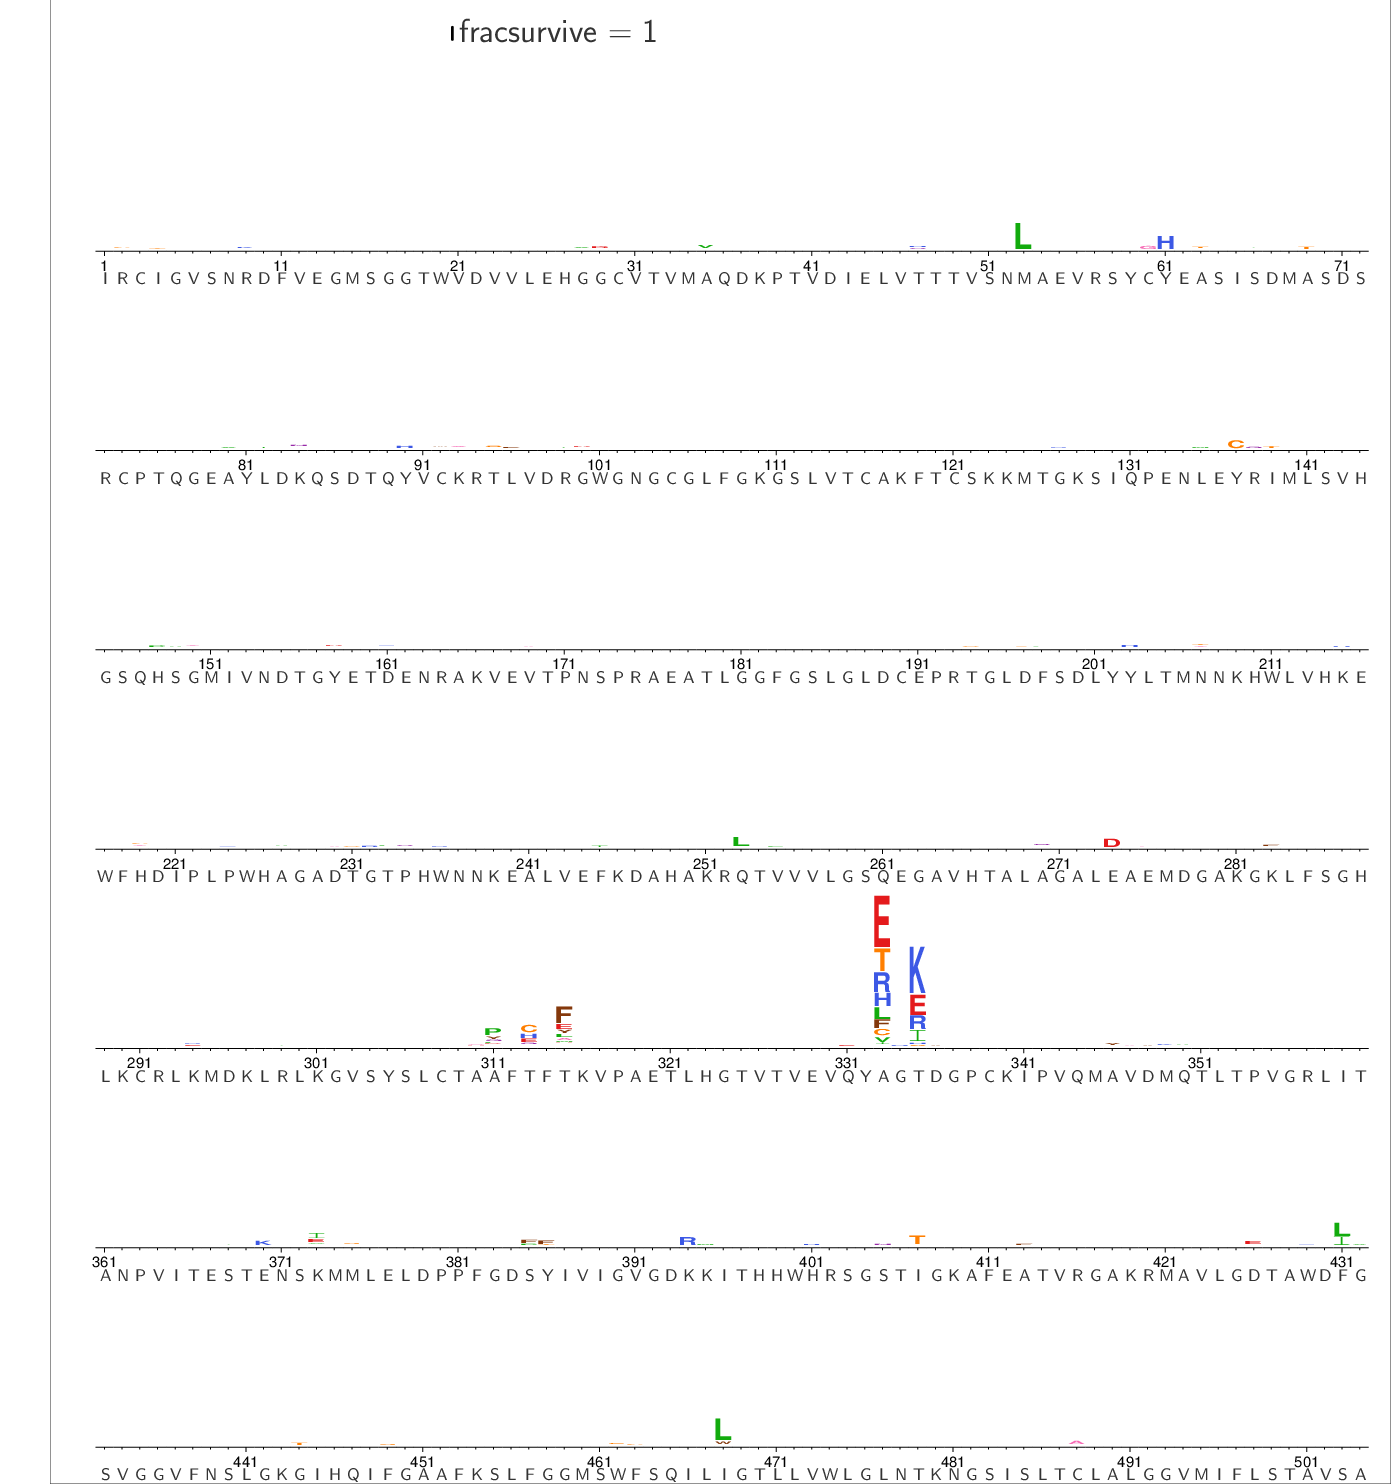



Fracsurvive for ZKA185 (plot saved to ./results/logoplots/ZKA185_fracsurvive.pdf):


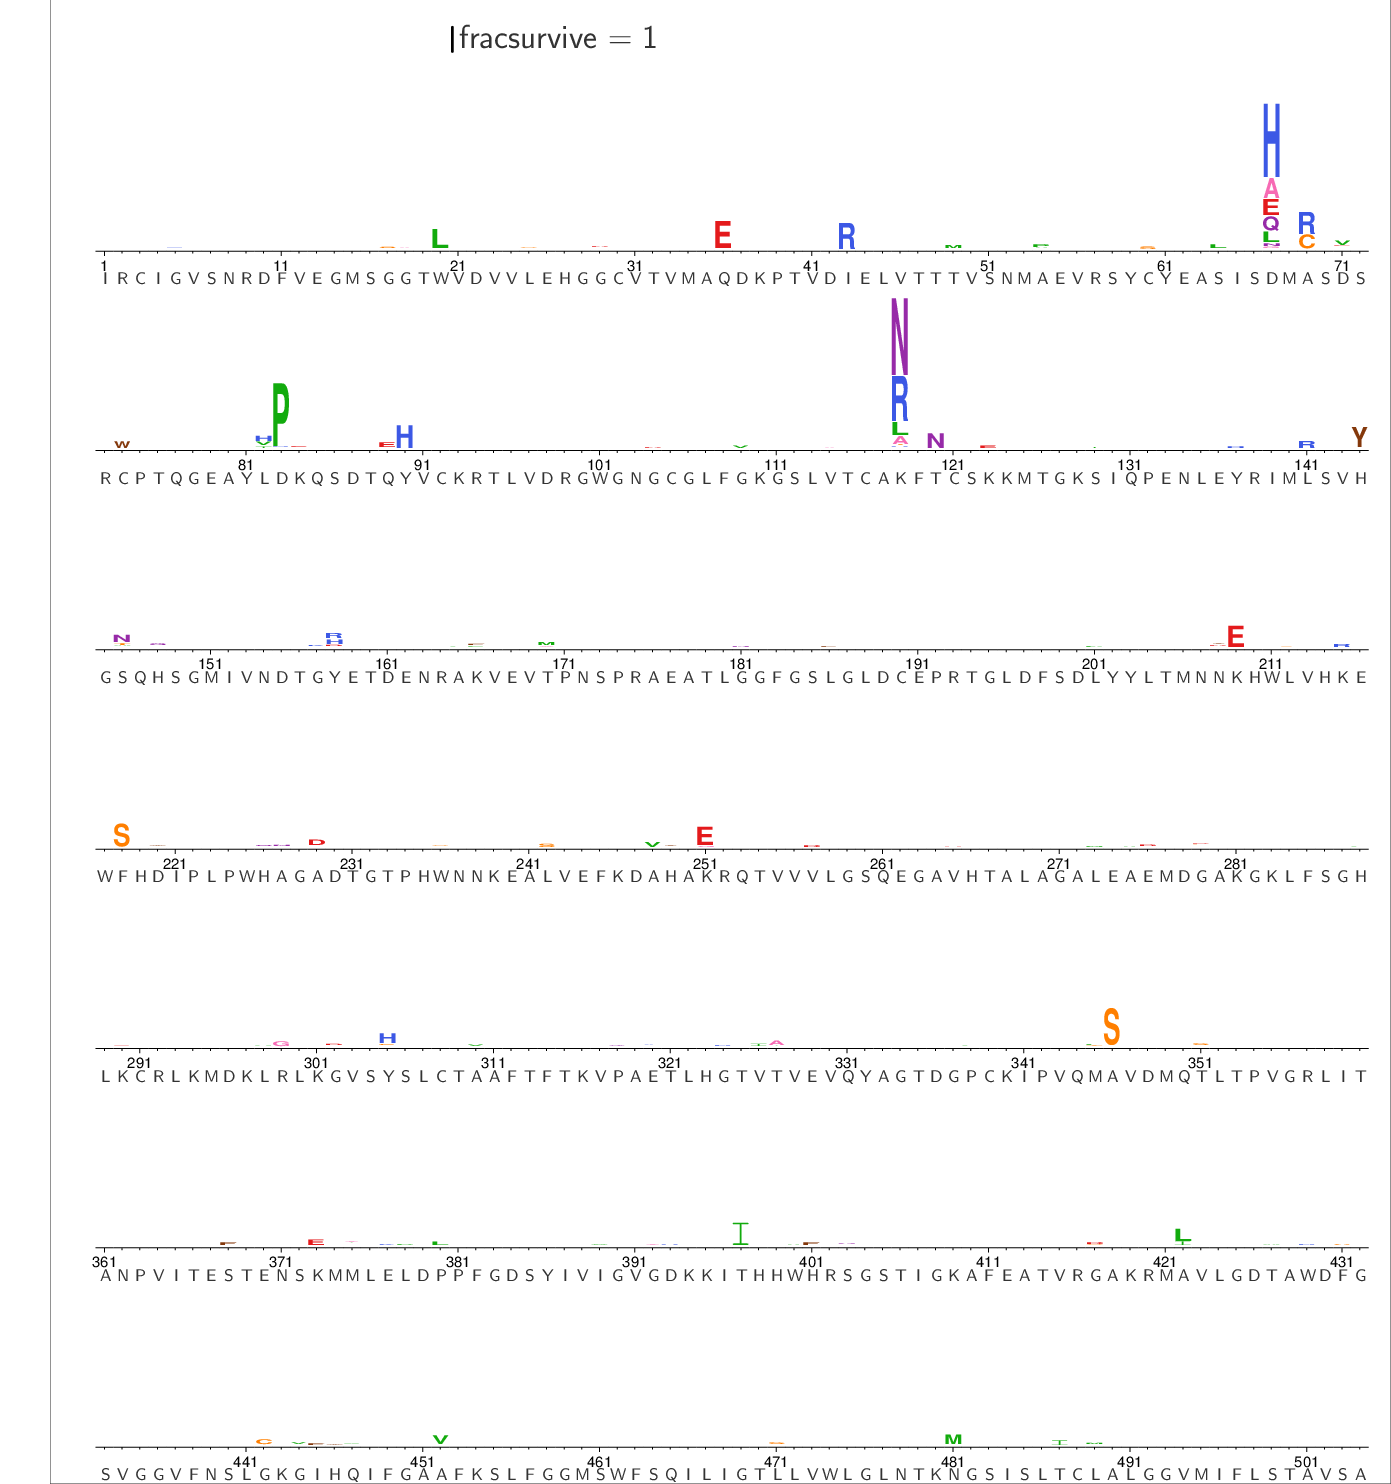

In [42]:
for antibody in diffsel_batch.query('group != "control-antibody"').group.unique():
    logoplot = os.path.join(logodir, f"{antibody}_fracsurvive.pdf")
    fracsurvivefile = os.path.join(fracsurvivedir,
                               f'summary_{antibody}-meanmutfracsurvive.csv')
    print(f"\n\nFracsurvive for {antibody} (plot saved to {logoplot}):")
    log = ! dms2_logoplot \
        --outdir {logodir} \
        --name {antibody} \
        --fracsurvive {fracsurvivefile} \
        --nperline 72 \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --scalebar 1 "fracsurvive = 1" \
        --underlay yes \
        --use_existing {use_existing}
    showPDF(logoplot)

The results for fraction surviving look mostly similar to those for differential selection, but there are some differences, and it is probably worth considering which metric seems to better capture the real biology.